# Details:
Name: Anushka Chaubey<br>
Roll: 12

In [281]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import markers

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, 
    classification_report, average_precision_score, f1_score, mutual_info_score, mean_squared_error, accuracy_score, 
)


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Gradient Boosting Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

# Probabilistic and Boosting Models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # To enable experimental features
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier


import re
import warnings
from sklearn.exceptions import ConvergenceWarning
from collections import Counter
import shap


from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



# Data Setup

In [282]:
os.chdir('/Users/anushkachaubey/College/IDA/Project_still birth/')
dataRAW=pd.read_csv('data1_copy.csv')
dataRAW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4501 entries, 0 to 4500
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WHOWID          4501 non-null   object 
 1   ORIG_ID         4501 non-null   int64  
 2   PARTICIPANT_ID  4501 non-null   object 
 3   PW_AGE          4501 non-null   int64  
 4   PW_EDUCATION    4485 non-null   float64
 5   PREV_SB         4501 non-null   int64  
 6   PREV_MIS        4501 non-null   int64  
 7   PREV_PTB        4501 non-null   int64  
 8   PREV_MULTIP     4501 non-null   int64  
 9   PREV_CS         4501 non-null   int64  
 10  WEALTH_INDEX    4501 non-null   object 
 11  SINGLE_TWIN     4501 non-null   int64  
 12  GRAVIDITY       4501 non-null   int64  
 13  PARITY          4501 non-null   int64  
 14  LABOUR_HTN      4501 non-null   int64  
 15  LABOUR_24       4501 non-null   int64  
 16  BIRTH_OUTCOME   4501 non-null   int64  
 17  BABY_SEX        4501 non-null   i

In [283]:
dataCleaned=dataRAW.copy(deep=True)

<b> Remove -88, -77 since those are NA </b> <br><br>
Remove all rows where BIRTH_OUTCOME has -88 or -77

In [284]:
rows_to_drop = dataCleaned[dataCleaned['BIRTH_OUTCOME'].isin([-88, -77])].index
dataCleaned = dataCleaned.drop(rows_to_drop)
dataCleaned['BIRTH_OUTCOME'].value_counts()


BIRTH_OUTCOME
1    4280
2     106
Name: count, dtype: int64

<b>NOTE</b>
> BIRTH_OUTCOME {1}: Normal Birth <br>
> BIRTH_OUTCOME {2}: Still Birth

In [285]:
# Map 1 to 1 and 2 to 0 in the BIRTH_OUTCOME column
dataCleaned['BIRTH_OUTCOME'] = dataCleaned['BIRTH_OUTCOME'].map({1: 0, 2: 1})
print(dataCleaned['BIRTH_OUTCOME'].value_counts())


BIRTH_OUTCOME
0    4280
1     106
Name: count, dtype: int64


In [286]:
dataCleaned,dataVal = train_test_split(
        dataCleaned, test_size=0.2, random_state=42, stratify=dataCleaned['BIRTH_OUTCOME']
    )

## Grouping Data into 5 Buckets: clean

<b>Remove the below coloumns since they are not relavant:</b><br> <br>
'WHOWID', 'ORIG_ID', 'PARTICIPANT_ID', 'BABY_ID1', 'BABY_ID2','BABY_ID3','DEL_DATE'

In [287]:
keepCols=[
# socio-economic 
'PW_AGE',
'PW_EDUCATION',
'WEALTH_INDEX',
# past pregnancies
'PREV_SB',
'PREV_MIS',
'PREV_PTB',
'PREV_MULTIP',
'PREV_CS',
# gestational details
'SINGLE_TWIN',
'GRAVIDITY',
'PARITY',
'LABOUR_HTN',
'LABOUR_24',
'GAGEBRTH',
'APH',
#Birth Outcome
'BIRTH_OUTCOME',
'BABY_SEX',
'BIRTH_WEIGHT',
'BIRTH_OUTCOME1',
'BABY_SEX1',
'BIRTH_WEIGHT1',
'BIRTH_OUTCOME2',
'BABY_SEX2',
'BIRTH_WEIGHT2',
'BIRTH_OUTCOME3',
'BABY_SEX3',
'BIRTH_WEIGHT3',
'TYPEDELIV',
'age_death_b1',
'age_death_b2',
'age_death_b3',
# physiological
'SBP1',
'DBP1',
'UDIP_PROT1',
'SBP2',
'DBP2',
'UDIP_PROT2',
'SBP3',
'DBP3',
'UDIP_PROT3',
'SBP4',
'DBP4',
'UDIP_PROT4',
'MAT_WEIGHT'
]

In [288]:
dataCleaned=dataCleaned[keepCols]

<b> Count the previous birth outcomes. </b><br><br>
1. Create a new column for no of previous still births
2. Create a new column for no of previous healthy births

In [289]:
# Define the conditions
stillbirth_condition = 2
normal_condition = 1

# Calculate counts for each row
dataCleaned['stillbirthCount'] = dataCleaned[['BIRTH_OUTCOME2', 'BIRTH_OUTCOME3']].apply(
    lambda row: sum(outcome == stillbirth_condition for outcome in row), axis=1
)
dataCleaned['normalbirthCount'] = dataCleaned[['BIRTH_OUTCOME2', 'BIRTH_OUTCOME3']].apply(
    lambda row: sum(outcome == normal_condition for outcome in row), axis=1
)


<b> Now we only consider Birth_outcome, stillBirthCount, NormalbirthCount </b>

In [290]:
dropcol=[
    'BIRTH_OUTCOME2',
    'BABY_SEX2',
    'BIRTH_WEIGHT2',
    'BIRTH_OUTCOME3',
    'BABY_SEX3',
    'BIRTH_WEIGHT3',
    'age_death_b1',
    'age_death_b2',
    'age_death_b3'
]

dataCleaned = dataCleaned.drop(columns=dropcol)

<b> Select relavant features </b> <br><br>
1. Birth weight already exists, hence remove birth_weight1 <br>
2. Keep SBP1, DBP1, UDIP_PROT1, remove rest

In [291]:
removeCols=["BIRTH_WEIGHT1","SBP2","DBP2","UDIP_PROT2","SBP3","DBP3","UDIP_PROT3","SBP4","DBP4","UDIP_PROT4"]
dataCleaned.drop(columns=removeCols,inplace=True)


<b> Examine similar named features </b> <br>
1. LABOUR_HTN & LABOUR_24
2. BIRTH_OUTCOME & BIRTH_OUTCOME1
3. BABY_SEX & BABY_SEX1

<b> Remove similar named features </b><br><br>
BIRTH_OUTCOME and BIRTH_OUTCOME1 are the same <br>
BABY_SEX and BABY_SEX1 are the same <br>
LABOUR_HTN and LABOUR_24 can be substituted. LABOUR_24 is better


In [292]:
removeCols=["LABOUR_HTN","BABY_SEX1","BIRTH_OUTCOME1"]
dataCleaned.drop(columns=removeCols,inplace=True)

<b> All removed columns </b><br><br>
'WHOWID', 'ORIG_ID', 'PARTICIPANT_ID', 'BABY_ID1', 'BABY_ID2','BABY_ID3','DEL_DATE'<br>
'BABY_ID1', 'BABY_ID2', 'BIRTH_OUTCOME2', 'BABY_SEX2', 'BIRTH_WEIGHT2', 'BABY_ID3', 'BIRTH_OUTCOME3', 'BABY_SEX3','BIRTH_WEIGHT3', 'age_death_b1', 'age_death_b2' ,'age_death_b3' <br>
"BIRTH_WEIGHT1", "SBP2", "DBP2", "UDIP_PROT2", "SBP3", "DBP3", "UDIP_PROT3", "SBP4", "DBP4" ,"UDIP_PROT4" <br>
"LABOUR_HTN", "BABY_SEX1", "BIRTH_OUTCOME1"


<b> Datatype of features <b>

In [293]:
columns_object_dtypes = dataCleaned.select_dtypes(include=['object']).columns
print("Object\n",columns_object_dtypes)

columns_float_dtypes = dataCleaned.select_dtypes(include=['float64']).columns
print("float\n",columns_float_dtypes)

columns_float_dtypes = dataCleaned.select_dtypes(include=['int']).columns
print("Int\n",columns_float_dtypes)


Object
 Index(['WEALTH_INDEX', 'TYPEDELIV'], dtype='object')
float
 Index(['PW_EDUCATION', 'GAGEBRTH', 'APH', 'BIRTH_WEIGHT', 'SBP1', 'DBP1',
       'UDIP_PROT1', 'MAT_WEIGHT'],
      dtype='object')
Int
 Index(['PW_AGE', 'PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS',
       'SINGLE_TWIN', 'GRAVIDITY', 'PARITY', 'LABOUR_24', 'BIRTH_OUTCOME',
       'BABY_SEX', 'stillbirthCount', 'normalbirthCount'],
      dtype='object')


<b> Evaluate 'OBJECT' datatype </b>
- Unique values of WEALTH_INDEX
- Unique values of TYPEDELIV

In [294]:
print("WEALTH_INDEX\n",dataCleaned['WEALTH_INDEX'].unique())
print("\nTYPEDELIV\n",dataCleaned['TYPEDELIV'].unique())


WEALTH_INDEX
 ['Rich' 'Richest' 'Middle' 'Poor' 'Poorest' "Don't know"]

TYPEDELIV
 ['Caesarean Section' 'Normally through the vagina' nan
 'Assisted delivery eg Forceps or vacuum']


<b> Encoding categories to numerical </b>

In [295]:
dataCleaned['WEALTH_INDEX'] = dataCleaned['WEALTH_INDEX'].replace({
    'Middle': 3,
    'Poor': 2,
    'Richest': 5,
    'Rich': 4,
    'Poorest': 1,
    "Don't know": np.nan,
    'nan': np.nan  

})

print(dataCleaned['WEALTH_INDEX'].head())

dataCleaned['TYPEDELIV'] = dataCleaned['TYPEDELIV'].replace({
    'Normally through the vagina': 0,
    'Caesarean Section': 1,
    'Assisted delivery eg Forceps or vacuum': 2,
    'nan': np.nan  
})

print(dataCleaned['TYPEDELIV'].head())



2640    4.0
536     5.0
1943    3.0
3919    2.0
2713    5.0
Name: WEALTH_INDEX, dtype: float64
2640    1.0
536     0.0
1943    0.0
3919    0.0
2713    0.0
Name: TYPEDELIV, dtype: float64


In [296]:
columns_object_dtypes = dataCleaned.select_dtypes(include=['object']).columns
print("Object\n",columns_object_dtypes)

columns_float_dtypes = dataCleaned.select_dtypes(include=['float64']).columns
print("float\n",columns_float_dtypes)

columns_float_dtypes = dataCleaned.select_dtypes(include=['int']).columns
print("int\n",columns_float_dtypes)

Object
 Index([], dtype='object')
float
 Index(['PW_EDUCATION', 'WEALTH_INDEX', 'GAGEBRTH', 'APH', 'BIRTH_WEIGHT',
       'TYPEDELIV', 'SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT'],
      dtype='object')
int
 Index(['PW_AGE', 'PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS',
       'SINGLE_TWIN', 'GRAVIDITY', 'PARITY', 'LABOUR_24', 'BIRTH_OUTCOME',
       'BABY_SEX', 'stillbirthCount', 'normalbirthCount'],
      dtype='object')


<b> Checking columns with values -77 or -88

In [297]:
# Find columns that contain -88 or -77
columns_with_values = [col for col in dataCleaned.columns if dataCleaned[col].isin([-88, -77]).any()]

# Display the list of column names
print(columns_with_values)

['PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS', 'GRAVIDITY', 'PARITY', 'LABOUR_24', 'BABY_SEX', 'UDIP_PROT1']


<b> Replace -77 and -88 with NAN 

In [298]:
dataCleaned.replace([-77, -88], np.nan, inplace=True)

## Data Cleaning Outcome 

In [299]:
missingValues=dataCleaned.isna().sum()
missingValues=missingValues[missingValues>0]
missing=dataCleaned[dataCleaned.isnull().any(axis=1)]
print("All Data: ",dataCleaned.shape)
print("Missing: ",missing.shape)

All Data:  (3508, 24)
Missing:  (1279, 24)


# Feature Engineering

Past Pregnancy Data: 'PREV_SB','PREV_MIS','PREV_PTB','PREV_MULTIP','PREV_CS','stillbirthCount','normalbirthCount'
Socio-economic Data: 'PW_AGE','PW_EDUCATION','WEALTH_INDEX'
Physiological Data : 'SBP1','DBP1','UDIP_PROT1','MAT_WEIGHT'
Gestational Data: 'SINGLE_TWIN','GRAVIDITY','PARITY','LABOUR_24','GAGEBRTH','APH'
At Birth Data: 'BABY_SEX','BIRTH_WEIGHT','TYPEDELIV'
Label: 'BIRTH_OUTCOME'

### Dividing the features into different groups for analysis

>past pregnancies <br>
'PREV_SB',
'PREV_MIS',
'PREV_PTB',
'PREV_MULTIP',
'PREV_CS',
'stillbirthCount',
'normalbirthCount'

> socio-economic <br>
    'PW_AGE',
    'PW_EDUCATION',
    'WEALTH_INDEX',

> physiological <br>
'SBP1',
'DBP1',
'UDIP_PROT1',
'MAT_WEIGHT'

> gestational details<br>
'SINGLE_TWIN',
'GRAVIDITY',
'PARITY',
'LABOUR_24',
'GAGEBRTH',
'APH',

> Birth Outcome <br>
'BIRTH_OUTCOME',
'BABY_SEX',
'BIRTH_WEIGHT',
'TYPEDELIV',



<b> Creating buckets i.e grouping the features in different clusters

In [300]:
socio_data=dataCleaned[['PW_AGE',
    'PW_EDUCATION',
    'WEALTH_INDEX',
    'BIRTH_OUTCOME']].copy(deep=True)

prevPreg_data=dataCleaned[['PREV_SB',
'PREV_MIS',
'PREV_PTB',
'PREV_MULTIP',
'PREV_CS',
'stillbirthCount',
'normalbirthCount',
'BIRTH_OUTCOME']].copy(deep=True)

gestation_data=dataCleaned[['SINGLE_TWIN',
'GRAVIDITY',
'PARITY',
'LABOUR_24',
'GAGEBRTH',
'APH',
'BIRTH_OUTCOME']].copy(deep=True)

outcome_data=dataCleaned[[
'BIRTH_OUTCOME',
'BABY_SEX',
'BIRTH_WEIGHT',
'TYPEDELIV',
'stillbirthCount',
'normalbirthCount'
]].copy(deep=True)

physio_data=dataCleaned[['SBP1',
'DBP1',
'UDIP_PROT1',
'MAT_WEIGHT',
'BIRTH_OUTCOME']].copy(deep=True)


## Correlation per bucket

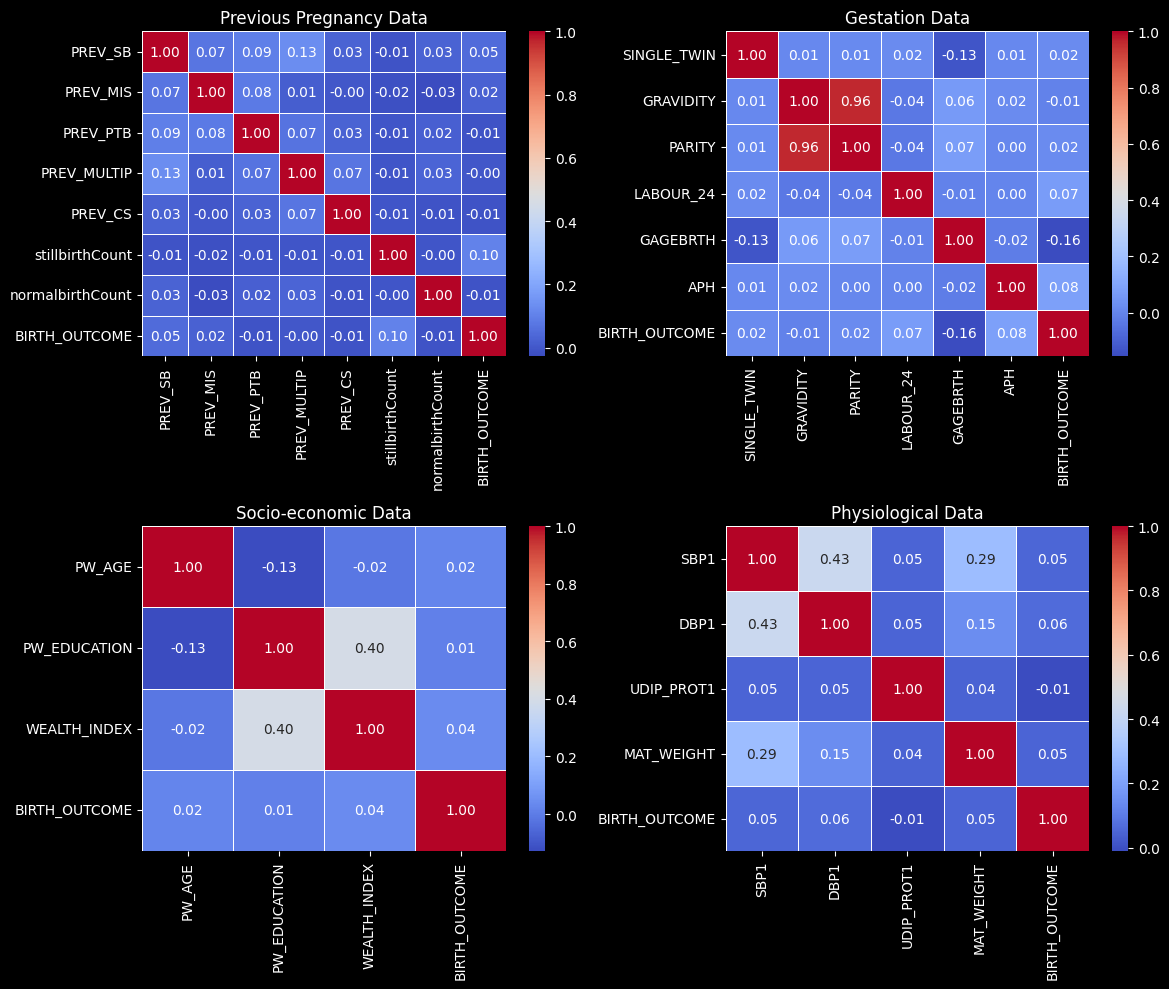

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 grid of subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Scatter plot
corr_matrix1 = prevPreg_data.corr(method='spearman')
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,ax=axes[0, 0])
axes[0, 0].set_title('Previous Pregnancy Data')

# Plot 2: Histogram
corr_matrix2 = gestation_data.corr(method='spearman')
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,ax=axes[0, 1])
axes[0, 1].set_title('Gestation Data')

# Plot 3: Box plot
corr_matrix3 = socio_data.corr(method='spearman')
sns.heatmap(corr_matrix3, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,ax=axes[1, 0])
axes[1, 0].set_title('Socio-economic Data')

# Plot 4: Correlation heatmap
corr_matrix4 = physio_data.corr(method='spearman')
sns.heatmap(corr_matrix4, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,ax=axes[1,1])
axes[1, 1].set_title('Physiological Data')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show()


# Data Cleaning, EDA on each categories

In [302]:
label=dataCleaned['BIRTH_OUTCOME']

### Previous Pregnancies

In [303]:
prevPreg_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3508 entries, 2640 to 1259
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PREV_SB           2893 non-null   float64
 1   PREV_MIS          2893 non-null   float64
 2   PREV_PTB          2734 non-null   float64
 3   PREV_MULTIP       2893 non-null   float64
 4   PREV_CS           2893 non-null   float64
 5   stillbirthCount   3508 non-null   int64  
 6   normalbirthCount  3508 non-null   int64  
 7   BIRTH_OUTCOME     3508 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 246.7 KB


#### Modifications

In [304]:
prevPreg_data_clean=prevPreg_data.copy(deep=True)

<b> Cant remove NA rows because they belong to still birth (imbalance data)

In [305]:
for x in ['PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS','stillbirthCount', 'normalbirthCount', 'BIRTH_OUTCOME']:
    missing_count = prevPreg_data[x].isnull().sum()  
    print(f"Column '{x}': {missing_count} missing rows.")

Column 'PREV_SB': 615 missing rows.
Column 'PREV_MIS': 615 missing rows.
Column 'PREV_PTB': 774 missing rows.
Column 'PREV_MULTIP': 615 missing rows.
Column 'PREV_CS': 615 missing rows.
Column 'stillbirthCount': 0 missing rows.
Column 'normalbirthCount': 0 missing rows.
Column 'BIRTH_OUTCOME': 0 missing rows.


<b> Uniques Values

In [306]:
for x in prevPreg_data_clean.columns:
    print(f"{x}: ",prevPreg_data_clean[x].value_counts())


PREV_SB:  PREV_SB
0.0    2609
1.0     284
Name: count, dtype: int64
PREV_MIS:  PREV_MIS
0.0    2256
1.0     460
2.0     124
3.0      38
4.0       6
6.0       4
5.0       3
7.0       2
Name: count, dtype: int64
PREV_PTB:  PREV_PTB
0.0    2647
1.0      87
Name: count, dtype: int64
PREV_MULTIP:  PREV_MULTIP
0.0    2796
1.0      97
Name: count, dtype: int64
PREV_CS:  PREV_CS
0.0    2808
1.0      85
Name: count, dtype: int64
stillbirthCount:  stillbirthCount
0    3504
1       4
Name: count, dtype: int64
normalbirthCount:  normalbirthCount
0    3441
1      67
Name: count, dtype: int64
BIRTH_OUTCOME:  BIRTH_OUTCOME
0    3423
1      85
Name: count, dtype: int64


<b> Fill the below with mode since its categorical data

In [307]:
for x in ['PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS']:
    mode=prevPreg_data[x].mode()[0]
    prevPreg_data_clean[x].fillna(mode,inplace=True)


In [308]:
missing=prevPreg_data_clean[prevPreg_data_clean.isnull().any(axis=1)]
print("All Data: ",prevPreg_data_clean.shape)
print("Missing: ",missing.shape)

All Data:  (3508, 8)
Missing:  (0, 8)


<b> Correlation between previous pregnancy data </b><br><br>
listing all columns with correlation greater than 0.07

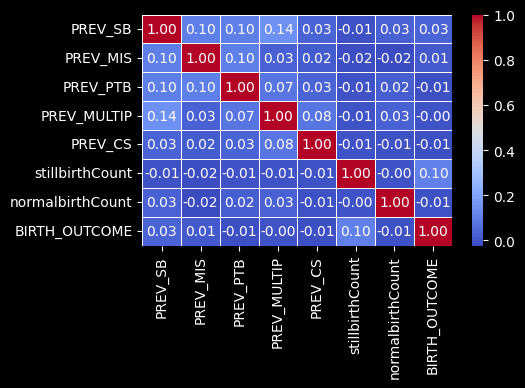

PREV_SB, PREV_MIS, Correlation: 0.09830178465721504
PREV_SB, PREV_PTB, Correlation: 0.10050823809228683
PREV_SB, PREV_MULTIP, Correlation: 0.1411539019875645
PREV_MIS, PREV_SB, Correlation: 0.09830178465721504
PREV_MIS, PREV_PTB, Correlation: 0.09936865931059038
PREV_PTB, PREV_SB, Correlation: 0.10050823809228683
PREV_PTB, PREV_MIS, Correlation: 0.09936865931059038
PREV_PTB, PREV_MULTIP, Correlation: 0.07371724015211935
PREV_MULTIP, PREV_SB, Correlation: 0.1411539019875645
PREV_MULTIP, PREV_PTB, Correlation: 0.07371724015211935
PREV_MULTIP, PREV_CS, Correlation: 0.07518293056023889
PREV_CS, PREV_MULTIP, Correlation: 0.07518293056023889
stillbirthCount, BIRTH_OUTCOME, Correlation: 0.10454213644107406
BIRTH_OUTCOME, stillbirthCount, Correlation: 0.10454213644107406


In [309]:
plt.figure(figsize=(5,3)) 

corr_matrix1 = prevPreg_data_clean.corr(method='spearman')
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

abs_corr_matrix = corr_matrix1.abs()
mask = abs_corr_matrix > 0.07
np.fill_diagonal(mask.values, False)
filtered_pairs = mask.stack()
filtered_pairs = filtered_pairs[filtered_pairs]

for (col1, col2), corr_value in filtered_pairs.items():
    corr_value = corr_matrix1.loc[col1, col2]
    print(f"{col1}, {col2}, Correlation: {corr_value}")

<b> One-hott encoding and scaling 

In [310]:
prevPreg_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3508 entries, 2640 to 1259
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PREV_SB           3508 non-null   float64
 1   PREV_MIS          3508 non-null   float64
 2   PREV_PTB          3508 non-null   float64
 3   PREV_MULTIP       3508 non-null   float64
 4   PREV_CS           3508 non-null   float64
 5   stillbirthCount   3508 non-null   int64  
 6   normalbirthCount  3508 non-null   int64  
 7   BIRTH_OUTCOME     3508 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 246.7 KB


In [311]:
prevPreg_encoded = pd.get_dummies(prevPreg_data_clean, columns=['PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS',
       'stillbirthCount', 'normalbirthCount'], drop_first=False)
prevPreg_encoded=prevPreg_encoded.astype(int)


In [312]:
scaler = StandardScaler()
prevPreg_encoded_scaled = scaler.fit_transform(prevPreg_encoded.drop(columns=['BIRTH_OUTCOME']))

prevPreg_encoded_scaled = pd.DataFrame(prevPreg_encoded_scaled, columns=prevPreg_encoded.drop(columns=['BIRTH_OUTCOME']).columns)
print(prevPreg_encoded_scaled.shape)
print(prevPreg_encoded_scaled.columns)

(3508, 20)
Index(['PREV_SB_0.0', 'PREV_SB_1.0', 'PREV_MIS_0.0', 'PREV_MIS_1.0',
       'PREV_MIS_2.0', 'PREV_MIS_3.0', 'PREV_MIS_4.0', 'PREV_MIS_5.0',
       'PREV_MIS_6.0', 'PREV_MIS_7.0', 'PREV_PTB_0.0', 'PREV_PTB_1.0',
       'PREV_MULTIP_0.0', 'PREV_MULTIP_1.0', 'PREV_CS_0.0', 'PREV_CS_1.0',
       'stillbirthCount_0', 'stillbirthCount_1', 'normalbirthCount_0',
       'normalbirthCount_1'],
      dtype='object')


<b> Performing LDA: Linear discriminant analysis to convert this bucket into 1 feature 

In [313]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X=prevPreg_encoded_scaled
y=prevPreg_data_clean['BIRTH_OUTCOME']
lda = LinearDiscriminantAnalysis(n_components=1)  # Number of components to keep

X_lda_prevPreg = lda.fit_transform(X, y)
print("Shape of transformed data:", X_lda_prevPreg.shape)
explained_variance_ratio = lda.explained_variance_ratio_
print("Explained variance ratio for each LDA component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {var:.4f}")

Shape of transformed data: (3508, 1)
Explained variance ratio for each LDA component:
Component 1: 1.0000


#### Previous Pregnancy Data outcome

In [314]:
print("Shape of transformed data:", X_lda_prevPreg.shape)
print("Missing values: ",np.isnan(X_lda_prevPreg).sum())

Shape of transformed data: (3508, 1)
Missing values:  0


### Gestational

In [315]:
gestation_data_clean=gestation_data.copy(deep=True)

In [316]:
gestation_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3508 entries, 2640 to 1259
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SINGLE_TWIN    3508 non-null   int64  
 1   GRAVIDITY      3498 non-null   float64
 2   PARITY         2893 non-null   float64
 3   LABOUR_24      3187 non-null   float64
 4   GAGEBRTH       3421 non-null   float64
 5   APH            3455 non-null   float64
 6   BIRTH_OUTCOME  3508 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 219.2 KB


#### Modifications

In [317]:
gestation_data_clean.columns

Index(['SINGLE_TWIN', 'GRAVIDITY', 'PARITY', 'LABOUR_24', 'GAGEBRTH', 'APH',
       'BIRTH_OUTCOME'],
      dtype='object')

In [318]:
for x in ['SINGLE_TWIN', 'GRAVIDITY', 'PARITY', 'LABOUR_24', 'GAGEBRTH', 'APH',
       'BIRTH_OUTCOME']:
    print(gestation_data_clean[x].value_counts())

SINGLE_TWIN
1    3437
2      71
Name: count, dtype: int64
GRAVIDITY
1.0     605
3.0     512
4.0     419
5.0     384
2.0     350
6.0     334
7.0     284
8.0     223
9.0     151
10.0    101
11.0     61
12.0     37
13.0     19
14.0     12
16.0      4
15.0      2
Name: count, dtype: int64
PARITY
2.0     502
3.0     444
1.0     401
4.0     400
5.0     379
6.0     237
7.0     207
8.0     127
9.0      63
0.0      60
10.0     43
11.0     15
12.0      8
13.0      4
14.0      2
15.0      1
Name: count, dtype: int64
LABOUR_24
0.0    3103
1.0      84
Name: count, dtype: int64
GAGEBRTH
279.0    173
277.0    167
276.0    167
280.0    148
278.0    142
        ... 
312.0      1
183.0      1
192.0      1
227.0      1
318.0      1
Name: count, Length: 120, dtype: int64
APH
0.0    3348
1.0     107
Name: count, dtype: int64
BIRTH_OUTCOME
0    3423
1      85
Name: count, dtype: int64


In [319]:
for x in gestation_data_clean.columns:
    missing_count = gestation_data[x].isnull().sum()  
    print(f"Column '{x}' has {missing_count} missing rows.")

Column 'SINGLE_TWIN' has 0 missing rows.
Column 'GRAVIDITY' has 10 missing rows.
Column 'PARITY' has 615 missing rows.
Column 'LABOUR_24' has 321 missing rows.
Column 'GAGEBRTH' has 87 missing rows.
Column 'APH' has 53 missing rows.
Column 'BIRTH_OUTCOME' has 0 missing rows.


In [320]:
for x in gestation_data.drop(columns=['BIRTH_OUTCOME','SINGLE_TWIN']).columns:
    print(x,gestation_data_clean[x].unique())

GRAVIDITY [ 4.  3.  6.  1.  5.  8.  7. 10. 12.  9. 11.  2. 14. 13. 15. nan 16.]
PARITY [ 1.  2.  3.  4. nan  6.  5.  9.  7. 10.  8.  0. 11. 12. 13. 14. 15.]
LABOUR_24 [ 0.  1. nan]
GAGEBRTH [295. 280. 281. 287. 262. 292. 239. 274. 269.  nan 268. 284. 293. 288.
 276. 285. 298. 271. 273. 270. 279. 272. 251. 275. 246. 277. 290. 266.
 278. 283. 294. 282. 265. 297. 235. 286. 289. 254. 258. 244. 291. 264.
 228. 248. 267. 216. 192. 296. 316. 221. 241. 250. 257. 307. 263. 256.
 231. 227. 259. 222. 240. 243. 245. 255. 300. 260. 302. 253. 301. 183.
 200. 312. 237. 252. 230. 299. 261. 236. 308. 315. 238. 191. 226. 242.
 249. 188. 311. 185. 247. 229. 213. 328. 181. 217. 219. 186. 199. 233.
 303. 215. 205. 211. 207. 180. 232. 306. 304. 193. 234. 189. 190. 309.
 209. 323. 305. 202. 177. 223. 179. 220. 318.]
APH [ 0.  1. nan]


In [321]:
for x in ['GRAVIDITY','PARITY','LABOUR_24','APH']:
    print(x,gestation_data_clean[x].value_counts())

GRAVIDITY GRAVIDITY
1.0     605
3.0     512
4.0     419
5.0     384
2.0     350
6.0     334
7.0     284
8.0     223
9.0     151
10.0    101
11.0     61
12.0     37
13.0     19
14.0     12
16.0      4
15.0      2
Name: count, dtype: int64
PARITY PARITY
2.0     502
3.0     444
1.0     401
4.0     400
5.0     379
6.0     237
7.0     207
8.0     127
9.0      63
0.0      60
10.0     43
11.0     15
12.0      8
13.0      4
14.0      2
15.0      1
Name: count, dtype: int64
LABOUR_24 LABOUR_24
0.0    3103
1.0      84
Name: count, dtype: int64
APH APH
0.0    3348
1.0     107
Name: count, dtype: int64


In [322]:
for x in ['GRAVIDITY','PARITY','GAGEBRTH']:
    print(x,gestation_data_clean[x].describe())

GRAVIDITY count    3498.000000
mean        4.632933
std         2.935036
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        16.000000
Name: GRAVIDITY, dtype: float64
PARITY count    2893.000000
mean        3.965434
std         2.442601
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        15.000000
Name: PARITY, dtype: float64
GAGEBRTH count    3421.000000
mean      275.357790
std        14.039877
min       177.000000
25%       271.000000
50%       277.000000
75%       283.000000
max       328.000000
Name: GAGEBRTH, dtype: float64


In [323]:
for x in ['GRAVIDITY','PARITY','GAGEBRTH']:
    med=gestation_data_clean[x].median()
    gestation_data_clean[x].fillna(med,inplace=True)

for x in ['LABOUR_24','APH']:
    mode=gestation_data_clean[x].mode()[0]
    gestation_data_clean[x].fillna(mode,inplace=True)


In [324]:
missing=gestation_data_clean[gestation_data_clean.isnull().any(axis=1)]
print("All Data: ",gestation_data_clean.shape)
print("Missing: ",missing.shape)


All Data:  (3508, 7)
Missing:  (0, 7)


<b> One-hot encoding and scaling

In [325]:
gestation_encoded = pd.get_dummies(gestation_data_clean, columns=['SINGLE_TWIN', 'APH', 'LABOUR_24'], drop_first=False)
gestation_encoded=gestation_encoded.astype(int)
gestation_encoded.columns

Index(['GRAVIDITY', 'PARITY', 'GAGEBRTH', 'BIRTH_OUTCOME', 'SINGLE_TWIN_1',
       'SINGLE_TWIN_2', 'APH_0.0', 'APH_1.0', 'LABOUR_24_0.0',
       'LABOUR_24_1.0'],
      dtype='object')

In [326]:
scaler = StandardScaler()
gestation_encoded_scaled = scaler.fit_transform(gestation_encoded.drop(columns=['BIRTH_OUTCOME']))

gestation_encoded_scaled = pd.DataFrame(gestation_encoded_scaled, columns=gestation_encoded.drop(columns=['BIRTH_OUTCOME']).columns)
print(gestation_encoded_scaled.shape)
print(gestation_encoded_scaled.columns)

(3508, 9)
Index(['GRAVIDITY', 'PARITY', 'GAGEBRTH', 'SINGLE_TWIN_1', 'SINGLE_TWIN_2',
       'APH_0.0', 'APH_1.0', 'LABOUR_24_0.0', 'LABOUR_24_1.0'],
      dtype='object')


In [327]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X=gestation_encoded_scaled
y=label
lda = LinearDiscriminantAnalysis(n_components=1)  # Number of components to keep

X_lda_gestation = lda.fit_transform(X, y)
print("Shape of transformed data:", X_lda_gestation.shape)
explained_variance_ratio = lda.explained_variance_ratio_
print("Explained variance ratio for each LDA component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {var:.4f}")

Shape of transformed data: (3508, 1)
Explained variance ratio for each LDA component:
Component 1: 1.0000


#### Gestational data outcome

In [328]:
print("Modified gestational data: ", gestation_encoded_scaled.shape)
print("Missing values: ", np.isnan(gestation_encoded_scaled).sum().sum())

Modified gestational data:  (3508, 9)
Missing values:  0


### Socio-economic

In [329]:
socio_data_clean=socio_data.copy(deep=True)

In [330]:
socio_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3508 entries, 2640 to 1259
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PW_AGE         3508 non-null   int64  
 1   PW_EDUCATION   3498 non-null   float64
 2   WEALTH_INDEX   3498 non-null   float64
 3   BIRTH_OUTCOME  3508 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 137.0 KB


#### Modifications

In [331]:
socio_data_clean.columns

Index(['PW_AGE', 'PW_EDUCATION', 'WEALTH_INDEX', 'BIRTH_OUTCOME'], dtype='object')

In [332]:
for x in socio_data.columns:
    missing_count = socio_data[x].isnull().sum()  # Count missing rows for each column
    print(f"Column '{x}' has {missing_count} missing rows.")

Column 'PW_AGE' has 0 missing rows.
Column 'PW_EDUCATION' has 10 missing rows.
Column 'WEALTH_INDEX' has 10 missing rows.
Column 'BIRTH_OUTCOME' has 0 missing rows.


In [333]:
for x in socio_data.columns:
    print(x,socio_data[x].unique())

PW_AGE [24 28 23 26 21 35 34 22 40 38 36 29 30 20 27 18 33 25 32 31 37 19 41 45
 39 42 43 44 46 47 49]
PW_EDUCATION [10.  6.  0. 15. 12. nan]
WEALTH_INDEX [ 4.  5.  3.  2.  1. nan]
BIRTH_OUTCOME [0 1]


In [334]:
for x in ['PW_EDUCATION', 'WEALTH_INDEX']:
    mode=socio_data[x].mode()[0]
    socio_data_clean[x].fillna(mode,inplace=True)


In [335]:
missing=socio_data_clean[socio_data_clean.isnull().any(axis=1)]
print("All Data: ",socio_data_clean.shape)
print("Missing: ",missing.shape)

All Data:  (3508, 4)
Missing:  (0, 4)


In [336]:
socio_data_clean.columns

Index(['PW_AGE', 'PW_EDUCATION', 'WEALTH_INDEX', 'BIRTH_OUTCOME'], dtype='object')

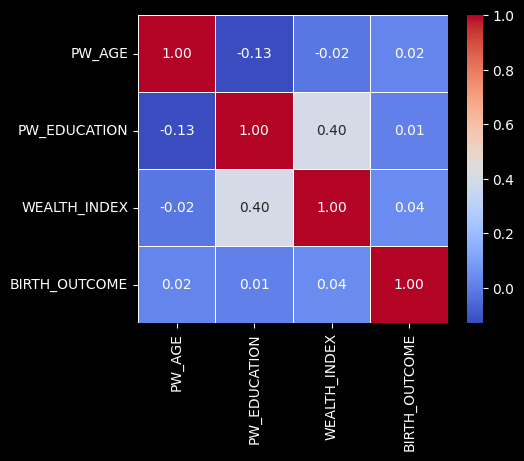

PW_AGE, PW_EDUCATION, Correlation: -0.12876847294838595
PW_EDUCATION, PW_AGE, Correlation: -0.12876847294838595
PW_EDUCATION, WEALTH_INDEX, Correlation: 0.3990631833564131
WEALTH_INDEX, PW_EDUCATION, Correlation: 0.3990631833564131


In [337]:
plt.figure(figsize=(5,4)) 

corr_matrix1 = socio_data_clean.corr(method='spearman')
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

# Calculate the absolute correlation matrix
abs_corr_matrix = corr_matrix1.abs()

# Create a mask for correlations where the absolute value is greater than 0.05
mask = abs_corr_matrix > 0.07

# Remove the diagonal (self-correlations)
np.fill_diagonal(mask.values, False)

# Extract the indices (row and column names) where correlations are > 0.05
filtered_pairs = mask.stack()

# Filter out pairs where correlation is not greater than 0.05
filtered_pairs = filtered_pairs[filtered_pairs]

# Print the combinations of columns and their corresponding correlation values
for (col1, col2), corr_value in filtered_pairs.items():
    corr_value = corr_matrix1.loc[col1, col2]
    print(f"{col1}, {col2}, Correlation: {corr_value}")

In [338]:
socio_data_clean.columns

Index(['PW_AGE', 'PW_EDUCATION', 'WEALTH_INDEX', 'BIRTH_OUTCOME'], dtype='object')

In [339]:
socio_encoded = pd.get_dummies(socio_data_clean, columns=['PW_EDUCATION', 'WEALTH_INDEX'], drop_first=False)
socio_encoded=socio_encoded.astype(int)
socio_encoded.shape

(3508, 12)

In [340]:
scaler = StandardScaler()
socio_encoded_scaled = scaler.fit_transform(socio_encoded.drop(columns=['BIRTH_OUTCOME']))

socio_encoded_scaled = pd.DataFrame(socio_encoded_scaled, columns=socio_encoded.drop(columns=['BIRTH_OUTCOME']).columns)
print(socio_encoded_scaled.shape)

(3508, 11)


In [341]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X=socio_encoded_scaled
y=socio_data_clean['BIRTH_OUTCOME']
lda = LinearDiscriminantAnalysis(n_components=1)  # Number of components to keep

X_lda_socio = lda.fit_transform(X, y)
print("Shape of transformed data:", X_lda_socio.shape)
explained_variance_ratio = lda.explained_variance_ratio_
print("Explained variance ratio for each LDA component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {var:.4f}")



Shape of transformed data: (3508, 1)
Explained variance ratio for each LDA component:
Component 1: 1.0000


#### Socio-economic data outcome

In [342]:
print("Modified data: ", X_lda_socio.shape)
print("Missing : ", np.isnan(X_lda_socio).sum())

Modified data:  (3508, 1)
Missing :  0


### Physiological Data

In [343]:
physio_data_clean=physio_data.copy(deep=True)

In [344]:
physio_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3508 entries, 2640 to 1259
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SBP1           3393 non-null   float64
 1   DBP1           3393 non-null   float64
 2   UDIP_PROT1     3370 non-null   float64
 3   MAT_WEIGHT     3252 non-null   float64
 4   BIRTH_OUTCOME  3508 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 164.4 KB


#### Modifications

In [345]:
physio_data_clean.columns

Index(['SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT', 'BIRTH_OUTCOME'], dtype='object')

In [346]:
for x in ['SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT', 'BIRTH_OUTCOME']:
    print(physio_data_clean[x].unique())

[115. 108. 106. 129.  98.  94. 110. 124. 113. 136. 116.  nan 111. 123.
 112. 101. 118. 104. 109. 120. 126. 131. 125. 119. 103. 114. 102. 135.
 121. 130. 127.  92. 132. 150. 117. 100. 107. 128.  95.  93.  97. 137.
 105. 134.  99. 133. 141. 122. 139.  91. 140.  96.  90. 148. 160. 142.
 151. 147. 205. 145. 149. 138. 144. 146. 186. 166. 159. 181. 143. 163.
 180. 201. 184. 153. 162. 154.]
[ 74.  78.  62.  92.  70.  79.  89.  60.  nan  64.  67.  66.  63.  73.
  76.  68.  72.  61.  80.  88.  69.  65.  77.  83.  71.  75.  81.  87.
  86.  82.  85.  90.  93. 111.  84.  97.  91. 115.  95. 119. 110.  98.
  94. 109. 101.  99. 118. 104.  58. 116.  96.  57. 117.]
[ 0.  2. nan]
[ 50.8  44.1  51.   64.4  49.8  64.3  67.   58.8  81.6 109.2   nan  57.3
  99.8  59.3  71.4  60.1  73.8  61.1  47.6  75.7  50.5  87.4  47.9  53.
  56.2  49.7  61.5  46.8  59.5  39.   59.2  63.3  90.1  62.2  51.2  54.4
  54.8  54.   54.3  68.8  56.6  55.6  78.5  66.3  53.5  57.4  58.7  87.
  54.5  61.8  51.5  58.3  66.1  42.2  5

In [347]:
physio_data_clean.columns

Index(['SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT', 'BIRTH_OUTCOME'], dtype='object')

In [348]:
for x in physio_data.columns:
    missing_count = physio_data[x].isnull().sum()  # Count missing rows for each column
    print(f"Column '{x}' has {missing_count} missing rows.")

Column 'SBP1' has 115 missing rows.
Column 'DBP1' has 115 missing rows.
Column 'UDIP_PROT1' has 138 missing rows.
Column 'MAT_WEIGHT' has 256 missing rows.
Column 'BIRTH_OUTCOME' has 0 missing rows.


In [349]:
np.unique(physio_data['UDIP_PROT1'],return_counts=True)

(array([ 0.,  2., nan]), array([2929,  441,  138]))

In [350]:
for x in physio_data.columns:
    print(x,physio_data[x].describe())

SBP1 count    3393.000000
mean      114.155909
std        11.378414
min        90.000000
25%       107.000000
50%       114.000000
75%       120.000000
max       205.000000
Name: SBP1, dtype: float64
DBP1 count    3393.000000
mean       71.150604
std         7.806626
min        57.000000
25%        65.000000
50%        70.000000
75%        76.000000
max       119.000000
Name: DBP1, dtype: float64
UDIP_PROT1 count    3370.000000
mean        0.261721
std         0.674596
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: UDIP_PROT1, dtype: float64
MAT_WEIGHT count    3252.000000
mean       59.830658
std        13.685957
min        35.000000
25%        50.000000
50%        57.000000
75%        67.100000
max       125.000000
Name: MAT_WEIGHT, dtype: float64
BIRTH_OUTCOME count    3508.000000
mean        0.024230
std         0.153785
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.0

In [351]:
physio_data.columns

Index(['SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT', 'BIRTH_OUTCOME'], dtype='object')

In [352]:
for x in ['SBP1', 'DBP1', 'MAT_WEIGHT']:
    mean=physio_data[x].mean()
    physio_data_clean[x].fillna(mean,inplace=True)

mode=physio_data['UDIP_PROT1'].mode()[0]
physio_data_clean['UDIP_PROT1'].fillna(mode,inplace=True)


In [353]:
missing=physio_data_clean[physio_data_clean.isnull().any(axis=1)]
print("All Data: ",physio_data_clean.shape)
print("Missing: ",missing.shape)

All Data:  (3508, 5)
Missing:  (0, 5)


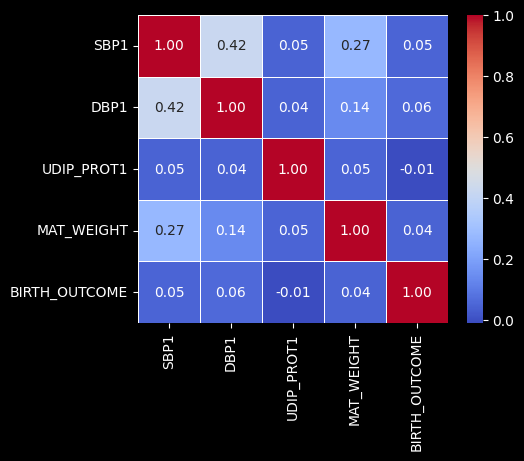

SBP1, DBP1, Correlation: 0.4230681560567265
SBP1, MAT_WEIGHT, Correlation: 0.2720128419065499
DBP1, SBP1, Correlation: 0.4230681560567265
DBP1, MAT_WEIGHT, Correlation: 0.13846679495914976
MAT_WEIGHT, SBP1, Correlation: 0.2720128419065499
MAT_WEIGHT, DBP1, Correlation: 0.13846679495914976


In [354]:
plt.figure(figsize=(5,4)) 

corr_matrix1 = physio_data_clean.corr(method='spearman')
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()
abs_corr_matrix = corr_matrix1.abs()
mask = abs_corr_matrix > 0.07
np.fill_diagonal(mask.values, False)
filtered_pairs = mask.stack()
filtered_pairs = filtered_pairs[filtered_pairs]
for (col1, col2), corr_value in filtered_pairs.items():
    corr_value = corr_matrix1.loc[col1, col2]
    print(f"{col1}, {col2}, Correlation: {corr_value}")

In [355]:
physio_encoded = pd.get_dummies(physio_data_clean, columns=['UDIP_PROT1'], drop_first=False)
physio_encoded=physio_encoded.astype(int)
physio_encoded.shape

(3508, 6)

In [356]:
scaler = StandardScaler()
physio_encoded_scaled = scaler.fit_transform(physio_encoded.drop(columns=['BIRTH_OUTCOME']))

physio_encoded_scaled = pd.DataFrame(physio_encoded_scaled, columns=physio_encoded.drop(columns=['BIRTH_OUTCOME']).columns)
print(physio_encoded_scaled.shape)

(3508, 5)


In [357]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X=physio_encoded_scaled
y=physio_data_clean['BIRTH_OUTCOME']
lda = LinearDiscriminantAnalysis(n_components=1)  # Number of components to keep

X_lda_physio = lda.fit_transform(X, y)
print("Shape of transformed data:", X_lda_physio.shape)
explained_variance_ratio = lda.explained_variance_ratio_
print("Explained variance ratio for each LDA component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {var:.4f}")

Shape of transformed data: (3508, 1)
Explained variance ratio for each LDA component:
Component 1: 1.0000


In [358]:
physio_encoded_scaled.columns

Index(['SBP1', 'DBP1', 'MAT_WEIGHT', 'UDIP_PROT1_0.0', 'UDIP_PROT1_2.0'], dtype='object')

#### Physiological Data Outcome

In [359]:
print("Modified data: ",X_lda_physio.shape)
print("Missing values: ", np.isnan(X_lda_physio).sum())

Modified data:  (3508, 1)
Missing values:  0


### Outcome Data

In [360]:
outcome_data_clean=outcome_data.copy(deep=True)

In [361]:
outcome_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3508 entries, 2640 to 1259
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BIRTH_OUTCOME     3508 non-null   int64  
 1   BABY_SEX          3333 non-null   float64
 2   BIRTH_WEIGHT      3152 non-null   float64
 3   TYPEDELIV         3419 non-null   float64
 4   stillbirthCount   3508 non-null   int64  
 5   normalbirthCount  3508 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 191.8 KB


#### Modifications

In [362]:
outcome_data_clean.columns

Index(['BIRTH_OUTCOME', 'BABY_SEX', 'BIRTH_WEIGHT', 'TYPEDELIV',
       'stillbirthCount', 'normalbirthCount'],
      dtype='object')

In [363]:
for x in ['BIRTH_OUTCOME', 'BABY_SEX', 'BIRTH_WEIGHT', 'TYPEDELIV',
       'stillbirthCount', 'normalbirthCount']:
    print(outcome_data_clean[x].value_counts())

BIRTH_OUTCOME
0    3423
1      85
Name: count, dtype: int64
BABY_SEX
1.0    1727
2.0    1606
Name: count, dtype: int64
BIRTH_WEIGHT
3260.0    28
3400.0    23
3000.0    22
3520.0    20
3160.0    20
          ..
2490.0     1
2628.0     1
3658.0     1
2380.0     1
2515.0     1
Name: count, Length: 808, dtype: int64
TYPEDELIV
0.0    3276
1.0     137
2.0       6
Name: count, dtype: int64
stillbirthCount
0    3504
1       4
Name: count, dtype: int64
normalbirthCount
0    3441
1      67
Name: count, dtype: int64


In [364]:
baby_sex_mode = outcome_data['BABY_SEX'].mode()[0]  # Mode of the column
outcome_data_clean['BABY_SEX'].fillna(baby_sex_mode, inplace=True)

birth_weight_median = outcome_data['BIRTH_WEIGHT'].median()  # Median of the column
outcome_data_clean['BIRTH_WEIGHT'].fillna(birth_weight_median, inplace=True)

typedeliv_mode = outcome_data['TYPEDELIV'].mode()[0]  # Mode of the column
outcome_data_clean['TYPEDELIV'].fillna(typedeliv_mode, inplace=True)

In [365]:
missing=outcome_data_clean[outcome_data_clean.isnull().any(axis=1)]
print("All Data: ",outcome_data_clean.shape)
print("Missing: ",missing.shape)

All Data:  (3508, 6)
Missing:  (0, 6)


In [366]:
outcome_data_clean.columns

Index(['BIRTH_OUTCOME', 'BABY_SEX', 'BIRTH_WEIGHT', 'TYPEDELIV',
       'stillbirthCount', 'normalbirthCount'],
      dtype='object')

In [367]:
outcomeData_encoded = pd.get_dummies(outcome_data_clean, columns=['BABY_SEX', 'TYPEDELIV','stillbirthCount','normalbirthCount'], drop_first=False)
outcomeData_encoded=outcomeData_encoded.astype(int)
outcomeData_encoded.shape

(3508, 11)

In [368]:
scaler = StandardScaler()
outcomeData_encoded_scaled = scaler.fit_transform(outcomeData_encoded.drop(columns=['BIRTH_OUTCOME']))

outcomeData_encoded_scaled = pd.DataFrame(outcomeData_encoded_scaled, columns=outcomeData_encoded.drop(columns=['BIRTH_OUTCOME']).columns)
print(outcomeData_encoded_scaled.shape)
print(outcomeData_encoded_scaled.columns)

(3508, 10)
Index(['BIRTH_WEIGHT', 'BABY_SEX_1.0', 'BABY_SEX_2.0', 'TYPEDELIV_0.0',
       'TYPEDELIV_1.0', 'TYPEDELIV_2.0', 'stillbirthCount_0',
       'stillbirthCount_1', 'normalbirthCount_0', 'normalbirthCount_1'],
      dtype='object')


In [369]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X=outcomeData_encoded_scaled
y=label
lda = LinearDiscriminantAnalysis(n_components=1)  # Number of components to keep

X_lda_outcome = lda.fit_transform(X, y)
print("Shape of transformed data:", X_lda_outcome.shape)
explained_variance_ratio = lda.explained_variance_ratio_
print("Explained variance ratio for each LDA component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {var:.4f}")

Shape of transformed data: (3508, 1)
Explained variance ratio for each LDA component:
Component 1: 1.0000


#### Birth Outcome related data outcome

In [370]:
print("Modified data: ",outcomeData_encoded_scaled.shape)
print("Missing: ",np.isnan(outcomeData_encoded_scaled).sum().sum())

Modified data:  (3508, 10)
Missing:  0


In [371]:
print(X_lda_prevPreg.shape)
print(X_lda_socio.shape)
print(X_lda_physio.shape)
print(X_lda_gestation.shape)
print(X_lda_outcome.shape)

(3508, 1)
(3508, 1)
(3508, 1)
(3508, 1)
(3508, 1)


# V2: Usable Data

In [372]:
gestation_data_clean.columns

Index(['SINGLE_TWIN', 'GRAVIDITY', 'PARITY', 'LABOUR_24', 'GAGEBRTH', 'APH',
       'BIRTH_OUTCOME'],
      dtype='object')

In [373]:
print(prevPreg_data_clean.shape)
print(socio_data_clean.shape)
print(physio_data_clean.shape)
print(gestation_data_clean.shape)
dropcol=['GAGEBRTH','LABOUR_24']

(3508, 8)
(3508, 4)
(3508, 5)
(3508, 7)


In [374]:
print(prevPreg_encoded_scaled.columns)
print(socio_encoded_scaled.columns)
print(physio_encoded_scaled.columns)
print(gestation_encoded_scaled.columns)

Index(['PREV_SB_0.0', 'PREV_SB_1.0', 'PREV_MIS_0.0', 'PREV_MIS_1.0',
       'PREV_MIS_2.0', 'PREV_MIS_3.0', 'PREV_MIS_4.0', 'PREV_MIS_5.0',
       'PREV_MIS_6.0', 'PREV_MIS_7.0', 'PREV_PTB_0.0', 'PREV_PTB_1.0',
       'PREV_MULTIP_0.0', 'PREV_MULTIP_1.0', 'PREV_CS_0.0', 'PREV_CS_1.0',
       'stillbirthCount_0', 'stillbirthCount_1', 'normalbirthCount_0',
       'normalbirthCount_1'],
      dtype='object')
Index(['PW_AGE', 'PW_EDUCATION_0.0', 'PW_EDUCATION_6.0', 'PW_EDUCATION_10.0',
       'PW_EDUCATION_12.0', 'PW_EDUCATION_15.0', 'WEALTH_INDEX_1.0',
       'WEALTH_INDEX_2.0', 'WEALTH_INDEX_3.0', 'WEALTH_INDEX_4.0',
       'WEALTH_INDEX_5.0'],
      dtype='object')
Index(['SBP1', 'DBP1', 'MAT_WEIGHT', 'UDIP_PROT1_0.0', 'UDIP_PROT1_2.0'], dtype='object')
Index(['GRAVIDITY', 'PARITY', 'GAGEBRTH', 'SINGLE_TWIN_1', 'SINGLE_TWIN_2',
       'APH_0.0', 'APH_1.0', 'LABOUR_24_0.0', 'LABOUR_24_1.0'],
      dtype='object')


In [375]:
dropcol_scaled=['GAGEBRTH','LABOUR_24_0.0','LABOUR_24_1.0']


In [376]:
# usableData = pd.concat([prevPreg_encoded_scaled, socio_encoded_scaled,physio_encoded_scaled,gestation_encoded_scaled.drop(columns=dropcol_scaled)], axis=1)
X=pd.DataFrame(gestation_encoded_scaled.drop(columns=dropcol_scaled))
y=label
lda = LinearDiscriminantAnalysis(n_components=1)  

temp = lda.fit_transform(X, y)

print(X_lda_prevPreg.shape,X_lda_socio.shape,X_lda_physio.shape, temp.shape)



usableData = pd.concat([
    pd.DataFrame(X_lda_prevPreg, columns=['PrevPreg_Feature1']),   
    pd.DataFrame(X_lda_socio, columns=['Socio_Feature1']),           
    pd.DataFrame(X_lda_physio, columns=['Physio_Feature1']),     
    pd.DataFrame(temp,columns=['Gest_Feature1'])
    # gestation_encoded_scaled.drop(columns=dropcol_scaled)                
], axis=1)
print(type(usableData))  
print(usableData.shape)

(3508, 1)

 (3508, 1) (3508, 1) (3508, 1)
<class 'pandas.core.frame.DataFrame'>
(3508, 4)


In [377]:
usableData.columns

Index(['PrevPreg_Feature1', 'Socio_Feature1', 'Physio_Feature1',
       'Gest_Feature1'],
      dtype='object')

In [378]:
usableData_raw = pd.concat([prevPreg_data_clean.drop(columns=['BIRTH_OUTCOME']), socio_data_clean.drop(columns=['BIRTH_OUTCOME']),physio_data_clean.drop(columns=['BIRTH_OUTCOME']),gestation_data_clean.drop(columns=dropcol)], axis=1)
print(type(usableData_raw))  
print(usableData_raw.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS',
       'stillbirthCount', 'normalbirthCount', 'PW_AGE', 'PW_EDUCATION',
       'WEALTH_INDEX', 'SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT',
       'SINGLE_TWIN', 'GRAVIDITY', 'PARITY', 'APH', 'BIRTH_OUTCOME'],
      dtype='object')


In [379]:
import pandas as pd
from sklearn.metrics import mutual_info_score

def calculate_mutual_information(data):

    columns = data.columns
    mutual_info_matrix = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            if col1 == col2:
                mutual_info_matrix.loc[col1, col2] = 0  # Self-information gain is 0
            else:
                # Compute mutual information between the two columns
                mi_score = mutual_info_score(data[col1], data[col2])
                mutual_info_matrix.loc[col1, col2] = mi_score

    return mutual_info_matrix.astype(float)

def plot_mutual_information_heatmap(mutual_info_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(mutual_info_matrix, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Mutual Information Gain Heatmap")
    plt.show()

def identify_high_mutual_info_columns(mutual_info_matrix, threshold=0.8):
    high_mi_pairs = []
    for col1 in mutual_info_matrix.columns:
        for col2 in mutual_info_matrix.index:
            if col1 != col2 and mutual_info_matrix.loc[col1, col2] > threshold:
                high_mi_pairs.append((col1, col2))
    return high_mi_pairs



In [380]:
usableData.columns

Index(['PrevPreg_Feature1', 'Socio_Feature1', 'Physio_Feature1',
       'Gest_Feature1'],
      dtype='object')

In [381]:
print(usableData.shape,label.shape)
usableData = usableData.reset_index(drop=True)
label = label.reset_index(drop=True)
temp=pd.concat([usableData,label],axis=1)
print(temp.shape)

(3508, 4) (3508,)
(3508, 5)


# Mutual Info Gain

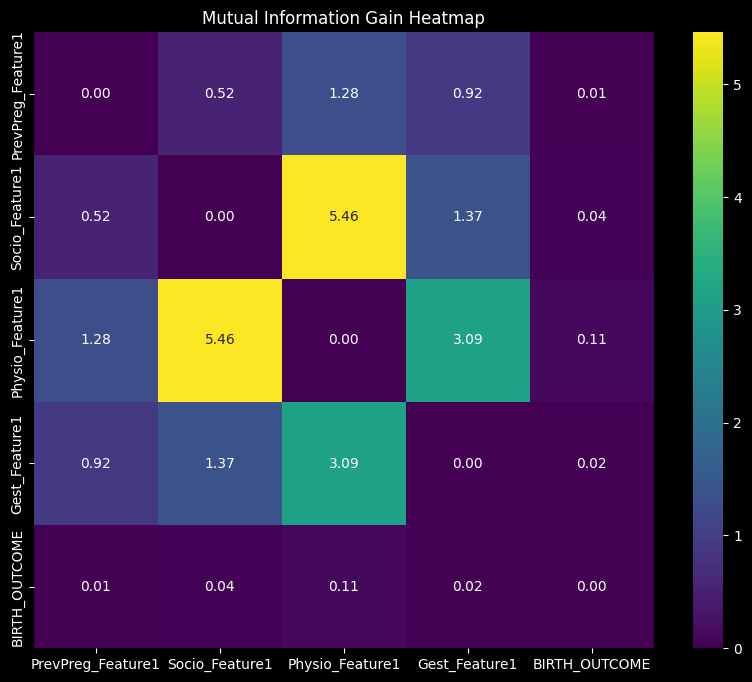

[('PrevPreg_Feature1', 'Physio_Feature1'),
 ('PrevPreg_Feature1', 'Gest_Feature1'),
 ('Socio_Feature1', 'Physio_Feature1'),
 ('Socio_Feature1', 'Gest_Feature1'),
 ('Physio_Feature1', 'PrevPreg_Feature1'),
 ('Physio_Feature1', 'Socio_Feature1'),
 ('Physio_Feature1', 'Gest_Feature1'),
 ('Gest_Feature1', 'PrevPreg_Feature1'),
 ('Gest_Feature1', 'Socio_Feature1'),
 ('Gest_Feature1', 'Physio_Feature1')]

In [382]:

mutual_info_df = calculate_mutual_information(temp)
plot_mutual_information_heatmap(mutual_info_df)
identify_high_mutual_info_columns(mutual_info_df)



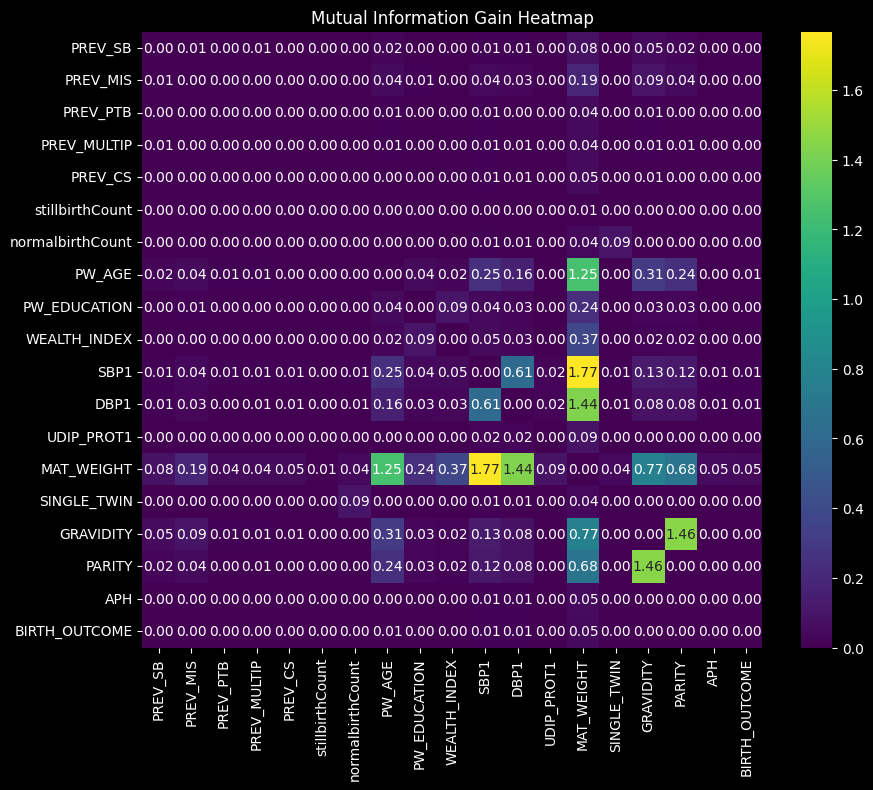

[('PW_AGE', 'MAT_WEIGHT'),
 ('SBP1', 'MAT_WEIGHT'),
 ('DBP1', 'MAT_WEIGHT'),
 ('MAT_WEIGHT', 'PW_AGE'),
 ('MAT_WEIGHT', 'SBP1'),
 ('MAT_WEIGHT', 'DBP1'),
 ('GRAVIDITY', 'PARITY'),
 ('PARITY', 'GRAVIDITY')]

In [383]:
mutual_info_df = calculate_mutual_information(usableData_raw)
plot_mutual_information_heatmap(mutual_info_df)
identify_high_mutual_info_columns(mutual_info_df)



In [384]:
X=usableData
y=label
lda = LinearDiscriminantAnalysis(n_components=1)  
usableData_lda = lda.fit_transform(X, y)
print("Shape of transformed data:", usableData_lda.shape)

Shape of transformed data: (3508, 1)


In [385]:
print("Scaled done to each bucket: ",usableData_raw.shape,'\n',usableData_raw.columns)
print()
print("LDA done to each bucket: ",usableData.shape,'\n',usableData.columns)
print()
print("LDA done on all 4 buckets with LDA: ",usableData_lda.shape)


Scaled done to each bucket:  (3508, 19) 
 Index(['PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS',
       'stillbirthCount', 'normalbirthCount', 'PW_AGE', 'PW_EDUCATION',
       'WEALTH_INDEX', 'SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT',
       'SINGLE_TWIN', 'GRAVIDITY', 'PARITY', 'APH', 'BIRTH_OUTCOME'],
      dtype='object')

LDA done to each bucket:  (3508, 4) 
 Index(['PrevPreg_Feature1', 'Socio_Feature1', 'Physio_Feature1',
       'Gest_Feature1'],
      dtype='object')

LDA done on all 4 buckets with LDA:  (3508, 1)


# Combinations of Features

1. Previous Pregnancy related data: LDA 1 component  (4386, 1)
2. Socio-economic related data: LDA 1 component (4386, 1)
3. Physiological related data: LDA 1 component (4386, 1)
4. Gestational Data: Encoded & Scaled (4386, 10)
5. Birth Outcome data: Encoded & Scaled (4386, 11)

### Combine LDA components 

#### 1. <b> X_lda_combined_prev_socio </b> = LDA(Previous pregnancy data) + LDA(Socio-economic data)

In [386]:
print(X_lda_prevPreg.shape, X_lda_socio.shape)
X_lda_prevPreg_df = pd.DataFrame(X_lda_prevPreg)
X_lda_socio_df = pd.DataFrame(X_lda_socio)
X_lda_combined_prev_socio = pd.concat([X_lda_prevPreg_df, X_lda_socio_df], axis=1)
X_lda_combined_prev_socio = X_lda_combined_prev_socio.to_numpy()
print(type(X_lda_combined_prev_socio))  
print(X_lda_combined_prev_socio.shape)

(3508, 1) (3508, 1)
<class 'numpy.ndarray'>
(3508, 2)


#### 2. <b> X_lda_combined_all </b> = LDA(Previous preg data) + LDA(Socio-economic data) + LDA(Physiological Data)

In [387]:
print(X_lda_prevPreg.shape, X_lda_socio.shape, X_lda_physio.shape)
X_lda_prevPreg_df = pd.DataFrame(X_lda_prevPreg)
X_lda_socio_df = pd.DataFrame(X_lda_socio)
X_lda_physio_df = pd.DataFrame(X_lda_physio)
X_lda_combined_all = pd.concat([X_lda_prevPreg_df, X_lda_socio_df,X_lda_physio_df], axis=1)
X_lda_combined_all = X_lda_combined_all.to_numpy()
print(type(X_lda_combined_all))  
print(X_lda_combined_all.shape)

(3508, 1) (3508, 1) (3508, 1)
<class 'numpy.ndarray'>
(3508, 3)


#### 3. <b>X_lda_combined_all2 </b> = LDA( LDA(Previous Pregnancy) + LDA(Socio-economical) )

In [388]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X=pd.DataFrame(X_lda_combined_prev_socio)
y=label
lda = LinearDiscriminantAnalysis(n_components=1)  

X_lda_combined_all2 = lda.fit_transform(X, y)
print("Shape of transformed data:", X_lda_combined_all2.shape)
explained_variance_ratio = lda.explained_variance_ratio_
print("Explained variance ratio for each LDA component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {var:.4f}")

Shape of transformed data: (3508, 1)
Explained variance ratio for each LDA component:
Component 1: 1.0000


#### 4. <b> X_lda_all5 </b>

In [389]:
print(X_lda_prevPreg.shape, X_lda_socio.shape, X_lda_physio.shape,X_lda_gestation.shape,X_lda_outcome.shape)

X_lda_all5 = pd.concat([
    pd.DataFrame(X_lda_prevPreg, columns=['PrevPreg_Feature1']),   
    pd.DataFrame(X_lda_socio, columns=['Socio_Feature1']),           
    pd.DataFrame(X_lda_physio, columns=['Physio_Feature1']),     
    pd.DataFrame(X_lda_gestation,columns=['Gest_Feature1']),
    pd.DataFrame(X_lda_outcome,columns=['Atbirth_Feature1'])

    # gestation_encoded_scaled.drop(columns=dropcol_scaled)                
], axis=1)

# X_lda_all5 = X_lda_all5.to_numpy()
print(type(X_lda_all5))  
print(X_lda_all5.shape)

(3508, 1) (3508, 1) (3508, 1) (3508, 1) (3508, 1)
<class 'pandas.core.frame.DataFrame'>
(3508, 5)


#### 5. <b>X_lda_all4</b>  prev + socio + physio + gest

In [390]:
print(X_lda_prevPreg.shape, X_lda_socio.shape, X_lda_physio.shape,X_lda_gestation.shape)
X_lda_prevPreg_df = pd.DataFrame(X_lda_prevPreg)
X_lda_socio_df = pd.DataFrame(X_lda_socio)
X_lda_physio_df = pd.DataFrame(X_lda_physio)
X_lda_gestation_df = pd.DataFrame(X_lda_gestation)

X_lda_all4 = pd.concat([X_lda_prevPreg_df, X_lda_socio_df,X_lda_physio_df,X_lda_gestation_df], axis=1)
X_lda_all4 = X_lda_all4.to_numpy()
print(type(X_lda_all4))  
print(X_lda_all4.shape)

(3508, 1) (3508, 1) (3508, 1) (3508, 1)
<class 'numpy.ndarray'>
(3508, 4)


#### 6. <b>All_5_DataScaled</b>  prev + socio + physio + gest + outcome scaled

In [391]:
d=[prevPreg_encoded_scaled,socio_encoded_scaled,physio_encoded_scaled,gestation_encoded_scaled,outcomeData_encoded_scaled]
All_5_DataScaled = pd.concat(d, axis=1)
print(type(All_5_DataScaled))  
print(All_5_DataScaled.shape)

<class 'pandas.core.frame.DataFrame'>
(3508, 55)


#### 7. <b>All_4_DataScaled</b>  prev + socio + physio + gest scaled


In [392]:
d=[prevPreg_encoded_scaled,socio_encoded_scaled,physio_encoded_scaled,gestation_encoded_scaled]
All_4_DataScaled = pd.concat(d, axis=1)
print(type(All_4_DataScaled))  
print(All_4_DataScaled.shape)

<class 'pandas.core.frame.DataFrame'>
(3508, 45)


#### 8. <b>All_3_DataScaled</b>  prev + socio + physio scaled


In [393]:
d=[prevPreg_encoded_scaled,socio_encoded_scaled,physio_encoded_scaled]
All_3_DataScaled = pd.concat(d, axis=1)
print(type(All_3_DataScaled))  
print(All_3_DataScaled.shape)

<class 'pandas.core.frame.DataFrame'>
(3508, 36)


In [394]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X=All_5_DataScaled
y=label
lda = LinearDiscriminantAnalysis(n_components=1)  

All_5_lda = lda.fit_transform(X, y)
print("Shape of transformed data:", All_5_lda.shape)
explained_variance_ratio = lda.explained_variance_ratio_
print("Explained variance ratio for each LDA component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {var:.4f}")

Shape of transformed data: (3508, 1)
Explained variance ratio for each LDA component:
Component 1: 1.0000


# Paramenter Tunning

In [395]:
warnings.filterwarnings("ignore")


def parameterTuning(X, y):
    # Stratified Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=label
    )

    # Apply SMOTE for balancing the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train = X_train_resampled
    y_train = y_train_resampled

# Parameter grids for GridSearchCV
    param_grids = {
        "Logistic Regression": {
            'C': [0.01, 0.1, 1],  # Reduced range
            'solver': ['liblinear'],  # 'saga' is useful for large datasets, but 'liblinear' is often sufficient
            'penalty': ['l1', 'l2'],
            'max_iter': [1000]  # No need for 10000
        },
        "Random Forest": {
            'n_estimators': [100, 200],  # 500 is rarely necessary
            'max_depth': [10, 20],  # Removed None
            'min_samples_split': [5, 10],  # 2 often leads to overfitting
            'min_samples_leaf':[2,4],  # Reduced range
            'max_features': ['sqrt','log2'],  # 'log2' is less commonly optimal
            'bootstrap': [True],  # False is less common
            'class_weight': ['balanced']
        },
        "Gaussian Naive Bayes": {
            'var_smoothing': [1e-9, 1e-7, 1e-5],
            'priors': [[0.5, 0.5], [0.7, 0.3],[0.9,0.1]]  # Priors can be adjusted based on class imbalance
        },
        "Decision Tree": {
            'max_depth': [10, 20],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'class_weight': ['balanced']
        },
        "XGBoost": {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'scale_pos_weight': [20, 40, 60]  # Added for handling imbalanced classes (adjust this based on class ratio)
            
        },
        "Bagging": {
            'n_estimators': [50, 100],
            'max_samples': [0.8, 1.0],
            'max_features': [0.5, 0.8],
            'bootstrap': [True],
            'bootstrap_features': [False]
        },
        "Boosting (AdaBoost)": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'algorithm': ['SAMME.R']
        },
        "Stacking": {
            'final_estimator__C': [0.1, 1],
            'final_estimator__penalty': ['l2', 'l1'],
            'final_estimator__solver': ['liblinear'],
            'final_estimator__max_iter': [1000],
        }
    }

    models = {
        # "Logistic Regression": LogisticRegression(class_weight='balanced',verbose=0),
        "Random Forest": RandomForestClassifier(class_weight='balanced', oob_score=True, verbose=0),
        # "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss',verbose=0),
        # "Gaussian Naive Bayes": GaussianNB(),
        # "Bagging": BaggingClassifier(),
        # "Boosting (AdaBoost)": AdaBoostClassifier(),
        # "Stacking": StackingClassifier(
        #     estimators=[
        #         ('lr', LogisticRegression(class_weight='balanced',verbose=0)),
        #         ('rf', RandomForestClassifier(class_weight='balanced')),
        #         ('nb', GaussianNB()),
        #         ('xgb', XGBClassifier(scale_pos_weight=1))
        #     ],
        #     final_estimator=LogisticRegression(verbose=0),
        #     cv= 5,
        #     n_jobs= -1
        # )
    }

    f1_scores = {}

    for model_name, model in models.items():
        warnings.filterwarnings("ignore")
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        print(f"Training and evaluating: {model_name}")

        # Perform Grid Search
        grid_search = GridSearchCV(
            model, param_grids[model_name], scoring='f1', cv=5, n_jobs=1, verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")

        # Train and predict probabilities
        best_model.fit(X_train, y_train)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        # Threshold Tuning
        thresholds = np.linspace(0.1, 0.9, 9)  # Thresholds from 0.1 to 0.9
        best_threshold = 0.5
        best_f1 = 0
        for threshold in thresholds:
            y_pred = (y_prob >= threshold).astype(int)
            f1 = f1_score(y_test, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        print(f"Best threshold for {model_name}: {best_threshold}, Best F1: {best_f1:.4f}")

        # Use the best threshold for final predictions
        y_pred = (y_prob >= best_threshold).astype(int)


        # Store the F1 Score
        f1_scores[model_name] = best_f1


    # Display the F1 scores for all models
    print("\nF1 Scores for All Models:")
    for model_name, score in f1_scores.items():
        print(f"{model_name}: {score:.4f}")


In [396]:
# warnings.filterwarnings("ignore")
# print("*"*20," lda usable data ","*"*20)
# X = All_5_DataScaled
# y=label
# parameterTuning(X,y)

In [397]:
# warnings.filterwarnings("ignore")
# print("*"*20," lda usable data ","*"*20)
# X = X_lda_all5
# y=label
# parameterTuning(X,y)

In [398]:
# warnings.filterwarnings("ignore")
# print("*"*20," lda usable data ","*"*20)
# X = usableData_lda
# y=label
# parameterTuning(X,y)

In [399]:
# warnings.filterwarnings("ignore")
# print("*"*20," lda usable data ","*"*20)
# X = usableData
# y=label
# parameterTuning(X,y)

# Best Model

In [400]:
from collections import Counter
def modelOutput(X,y):

    warnings.filterwarnings("ignore")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=label, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train=X_train_resampled
    y_train=y_train_resampled


    models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', bootstrap= True, max_depth= 10, max_features='sqrt', min_samples_leaf=4, min_samples_split= 10, n_estimators= 200),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced' , C= 0.01, penalty= 'l1', solver= 'liblinear'),
    "Support Vector Machine (SVM)": SVC(probability=True, kernel='rbf', class_weight='balanced'),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    "Gaussian Naive Bayes": GaussianNB(var_smoothing=1e-09,priors=[0.5, 0.5]), 
    "Bagging": BaggingClassifier(),
    "Boosting (AdaBoost)": AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 0.1, n_estimators= 100),
    "XGBoost": XGBClassifier(),
    "Stacking": StackingClassifier(
            estimators=[
                ('lr', LogisticRegression(max_iter=1000, class_weight='balanced' , C= 0.01, penalty= 'l1', solver= 'liblinear')),
                ('rf', RandomForestClassifier()),
                ('nb', GaussianNB()),
                ('xgb',XGBClassifier())
            ],
            final_estimator=LogisticRegression(C=0.1,max_iter=1000,penalty='l1',solver='liblinear'),
            cv=5,
            n_jobs=-1
        )
}




    f1_scores = {}

    for model_name, model in models.items():
        # print(f"Training and evaluating: {model_name}")
        model.fit(X_train, y_train)

        # Apply the threshold
        y_prob = model.predict_proba(X_test)[:, 1]
        y_train_prob = model.predict_proba(X_train)[:, 1]

        

        thresholds = {
        "Random Forest": 0.9,
        "Decision Tree": 0.9,
        "Logistic Regression": 0.7,
        "Gaussian Naive Bayes": 0.6, 
        "Bagging": 0.6,
        "Boosting (AdaBoost)": 0.5,
        ""
        "XGBoost": 0.9,
        "Stacking": 0.8
        }

        # Set the default threshold to 0.5 if the model is not specified in the dictionary
        threshold = thresholds.get(model_name, 0.5)

        y_pred = (y_prob >= threshold).astype(int)
        y_train_pred = (y_train_prob >= threshold).astype(int)

                # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(2, 2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        f1 = f1_score(y_test, y_pred) 
        f1_scores[model_name] = f1


    # Display the F1 scores for all models
    print("\nF1 Scores for All Models:")
    for model_name, score in f1_scores.items():
        print(f"{model_name}: {score:.4f}")
    
    # Display only the maximum F1 score and corresponding model
    max_model_name, max_f1_score = max(f1_scores.items(), key=lambda item: item[1])
    print(f"\nModel with the Maximum F1 Score:\n{max_model_name}: {max_f1_score:.4f}")


In [401]:
# warnings.filterwarnings("ignore")
# print("*"*20," lda usable data ","*"*20)
# X = usableData_lda
# y=label
# modelOutput(X,y)



In [402]:
# warnings.filterwarnings("ignore")
# print("*"*20," Physio_Feature1 ","*"*20)
# print(usableData.columns)
# X = X_lda_physio
# y=label
# modelOutput(X,y)

In [403]:
# warnings.filterwarnings("ignore")

# print("*"*20," scaled all 5 ","*"*20)
# X = All_5_DataScaled[['GAGEBRTH', 'LABOUR_24_0.0', 'LABOUR_24_1.0', 'BIRTH_WEIGHT', 'BABY_SEX_1.0', 'BABY_SEX_2.0', 'TYPEDELIV_0.0', 'TYPEDELIV_1.0', 'TYPEDELIV_2.0']]
# y=label
# modelOutput(X,y)


# Other methods 

In [404]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier


def newModels(X,y):
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize models
    models = {
        "EasyEnsemble": EasyEnsembleClassifier(),
        "Balanced Bagging": BalancedBaggingClassifier(),
        "AdaBoost": AdaBoostClassifier(),
        "XGBoost": xgb.XGBClassifier(scale_pos_weight=9),
        "LightGBM": lgb.LGBMClassifier(is_unbalanced=True),
        "CatBoost": CatBoostClassifier(class_weights=[1, 9], verbose=0)
    }

    # Train each model and calculate F1 score
    f1_scores = {}

    # Model training and evaluation loop
    for name, model in models.items():
        print(f"Training {name}...")
        if name == "AdaBoost":
            # SMOTEBoost requires oversampling on training set
            smote = SMOTE(sampling_strategy='minority')
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
            model.fit(X_train_res, y_train_res)
        else:
            model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate F1 score
        f1 = f1_score(y_test, y_pred)
        f1_scores[name] = f1

    # Display the F1 scores for each model
    print("\nF1 Scores of Models:")
    for model_name, score in f1_scores.items():
        print(f"{model_name}: {score:.4f}")


In [405]:
# warnings.filterwarnings("ignore")
# print("*"*20," lda usable data ","*"*20)
# X = usableData_lda
# y=label
# newModels(X,y)



# warnings.filterwarnings("ignore")
# print("*"*20," usable data ","*"*20)
# print(usableData.columns)
# X = usableData
# y=label
# newModels(X,y)

In [406]:

def newParaTunning(X, y):
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=label, test_size=0.3, random_state=42)

    # Initialize models
    models = {
        "LightGBM": lgb.LGBMClassifier(verbose=-1),
        "EasyEnsemble": EasyEnsembleClassifier(verbose=0),
        "Balanced Bagging": BalancedBaggingClassifier(verbose=0),
        "AdaBoost (with class weights)": AdaBoostClassifier(),
        "XGBoost": xgb.XGBClassifier(),
        "CatBoost": CatBoostClassifier(class_weights=[1, 9], verbose=0)
    }

    # Hyperparameters to tune
    param_grids = {
        "Random Forest (Balanced)": {
            'base_estimator__n_estimators': [50, 100, 200],
            'n_estimators': [50, 100],
            'max_samples': [0.5, 0.7, 1.0]
        },
        "EasyEnsemble": {
            'n_estimators': [50, 100],
        },
        "Balanced Bagging": {
            'n_estimators': [50, 100],
            'max_samples': [0.5, 0.7, 1.0]
        },
        "AdaBoost (with class weights)": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1]
        },
        "XGBoost": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7]
        },
        "LightGBM": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [10, 15],
            'class_weight': ['balanced', None]  # Add class_weight for handling imbalance
        },
        "CatBoost": {
            'iterations': [50, 100],
            'learning_rate': [0.01, 0.1],
            'depth': [6, 8]  # Use depth instead of max_depth for CatBoost
        }
    }

    # Function to perform grid search and get the best F1 score
    def perform_grid_search(model_name, model, param_grid):
        print(f"Performing Grid Search for {model_name}...")
        
        # For SMOTE models like AdaBoost (with class weights), apply SMOTE before grid search
        smote = SMOTE(sampling_strategy='minority')
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3, verbose=0)
        grid_search.fit(X_train_res, y_train_res)

        
        # Best F1 score
        best_f1_score = grid_search.best_score_
        best_params = grid_search.best_params_
        
        # Get the predictions for the test set
        y_pred = grid_search.best_estimator_.predict(X_test)
        test_f1_score = f1_score(y_test, y_pred)
        
        return best_f1_score, best_params, test_f1_score

    # Perform grid search for each model
    f1_scores = {}
    best_params = {}

    for name, model in models.items():
        best_score, params, test_score = perform_grid_search(name, model, param_grids[name])
        f1_scores[name] = test_score
        best_params[name] = params

    # Display the F1 scores and best parameters for each model
    print("\nBest Parameters and F1 Scores of Models:")
    for model_name in f1_scores:
        print(f"{model_name}:\n  Best F1 Score (Train): {f1_scores[model_name]:.4f}\n  Best Parameters: {best_params[model_name]}")


In [407]:
# warnings.filterwarnings("ignore")
# print("*"*20," lda usable data ","*"*20)
# X = usableData_lda
# y=label
# newParaTunning(X,y)



# warnings.filterwarnings("ignore")
# print("*"*20," usable data ","*"*20)
# print(usableData.columns)
# X = usableData
# y=label
# newParaTunning(X,y)

# Shapley

In [408]:
np.unique(label,return_counts=True)

(array([0, 1]), array([3423,   85]))

In [409]:
from collections import Counter
from sklearn.metrics import f1_score, recall_score, precision_score

def modelOutput(X,y):

    warnings.filterwarnings("ignore")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=label, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train=X_train_resampled
    y_train=y_train_resampled


    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced' , C= 0.01, penalty= 'l1', solver= 'liblinear'),
        # "Gaussian Naive Bayes": GaussianNB(var_smoothing=1e-09,priors=[0.5, 0.5]), 
        "Random Forest": RandomForestClassifier(class_weight='balanced', bootstrap= True, max_depth= 20, max_features='sqrt', min_samples_leaf=2, min_samples_split= 5, n_estimators= 100),
        # "Boosting":AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 0.1, n_estimators= 100)

    }




    f1_scores = {}

    for model_name, model in models.items():
        # print(f"Training and evaluating: {model_name}")
        model.fit(X_train, y_train)

        # Apply the threshold
        y_prob = model.predict_proba(X_test)[:, 1]
        y_train_prob = model.predict_proba(X_train)[:, 1]

        

        thresholds = {
        "Logistic Regression": 0.65,
        "Gaussian Naive Bayes": 0.57, 
        "Boosting": 0.55,
        "Random Forest":0.3
        }

        # Set the default threshold to 0.5 if the model is not specified in the dictionary
        threshold = thresholds.get(model_name, 0.5)
        y_pred = (y_prob >= threshold).astype(int)
        y_train_pred = (y_train_prob >= threshold).astype(int)


        f1 = f1_score(y_test, y_pred) 
        f1_scores[model_name] = f1

                # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(2, 2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


        if model_name!="Non":
            f1_graph,recall_scores, precision_scores = [], [], []

            thresholds = np.linspace(0, 1, 50)
            for threshold in thresholds:
                y_pred = (y_prob >= threshold).astype(int)
                f1_graph.append(f1_score(y_test, y_pred))
                recall_scores.append(recall_score(y_test, y_pred))
                precision_scores.append(precision_score(y_test, y_pred))
            

            best_f1_threshold = thresholds[np.argmax(f1_graph)]
            best_precision_threshold = thresholds[np.argmax(precision_scores)]
            best_recall_threshold = thresholds[np.argmax(recall_scores)]
            
            print(f"Best F1 Score at threshold: {best_f1_threshold:.2f}")
            print(f"Best Precision at threshold: {best_precision_threshold:.2f}")
            print(f"Best Recall at threshold: {best_recall_threshold:.2f}")

            plt.figure(figsize=(12, 4))
    
            plt.subplot(1, 3, 1)
            plt.plot(thresholds, f1_graph, label='F1 Score', color='blue')
            plt.xlabel('Threshold')
            plt.ylabel('F1 Score')
            plt.title('F1 Score vs Threshold')
            plt.grid()
            
            plt.subplot(1, 3, 2)
            plt.plot(thresholds, recall_scores, label='Recall', color='green')
            plt.xlabel('Threshold')
            plt.ylabel('Recall')
            plt.title('Recall vs Threshold')
            plt.grid()
            
            plt.subplot(1, 3, 3)
            plt.plot(thresholds, precision_scores, label='Precision', color='red')
            plt.xlabel('Threshold')
            plt.ylabel('Precision')
            plt.title('Precision vs Threshold')
            plt.grid()
            
            plt.tight_layout()
            plt.show()





    # Display the F1 scores for all models
    print("\nF1 Scores for All Models:")
    for model_name, score in f1_scores.items():
        print(f"{model_name}: {score:.4f}")
    
    # Display only the maximum F1 score and corresponding model
    max_model_name, max_f1_score = max(f1_scores.items(), key=lambda item: item[1])
    print(f"\nModel with the Maximum F1 Score:\n{max_model_name}: {max_f1_score:.4f}")


********************  lda usable data  ********************


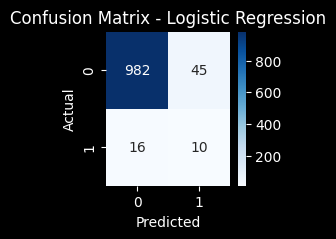

Best F1 Score at threshold: 0.71
Best Precision at threshold: 0.98
Best Recall at threshold: 0.00


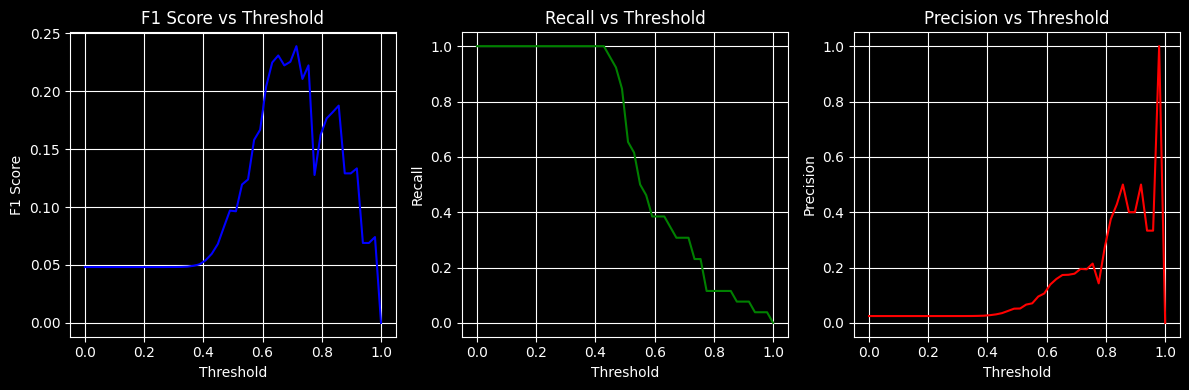

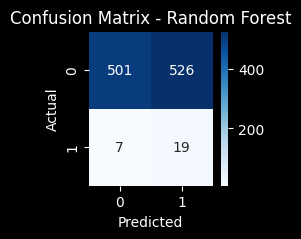

Best F1 Score at threshold: 0.88
Best Precision at threshold: 0.88
Best Recall at threshold: 0.00


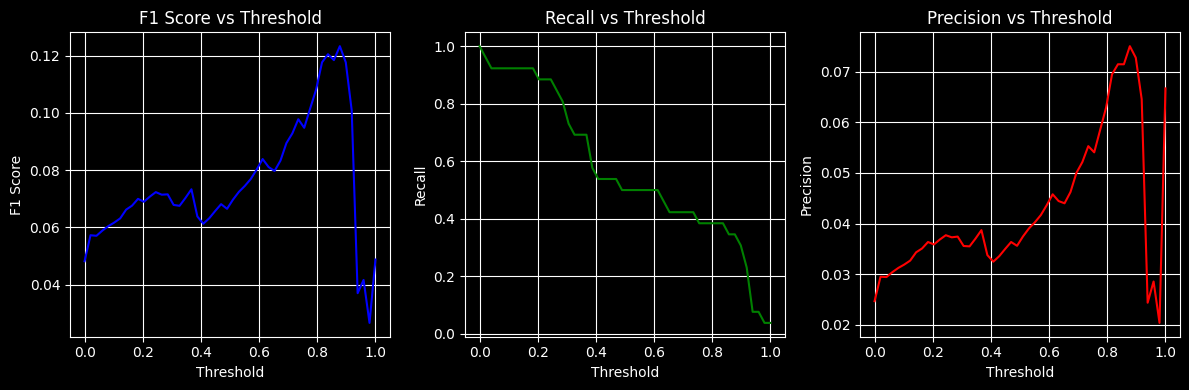


F1 Scores for All Models:
Logistic Regression: 0.2469
Random Forest: 0.0665

Model with the Maximum F1 Score:
Logistic Regression: 0.2469


In [410]:
warnings.filterwarnings("ignore")
print("*"*20," lda usable data ","*"*20)
X = usableData_lda
y=label
modelOutput(X,y)

In [411]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [412]:
import shap

def shapely(X,y):

    warnings.filterwarnings("ignore")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=label, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train=X_train_resampled
    y_train=y_train_resampled


    model =RandomForestClassifier(bootstrap= True, class_weight='balanced', max_depth= 20, max_features='sqrt', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 100)

    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    print(shap_values.shape)

    # shap.summary_plot(shap_values[:, :5, 0], X_train.iloc[:, :5], show=False)  # Plot first 5 features for class 0
    shap.summary_plot(shap_values[:, :5, 1], X_train.iloc[:, :5], show=False)  # Plot first 5 features for class 1


In [433]:
from collections import Counter
from sklearn.metrics import f1_score, recall_score, precision_score
import shap


def modelOutput(X,y):

    warnings.filterwarnings("ignore")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=label, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train=X_train_resampled
    y_train=y_train_resampled


    models = {
        # "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced' , C= 0.01, penalty= 'l1', solver= 'liblinear'),
        "Random Forest": RandomForestClassifier(bootstrap= True, class_weight='balanced', max_depth= 20, max_features='sqrt', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 100),

    }

    f1_scores = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)

        # Apply the threshold
        y_prob = model.predict_proba(X_test)[:, 1]
        y_train_prob = model.predict_proba(X_train)[:, 1]


        thresholds = {
        "Logistic Regression": 0.65,
        "Random Forest": 0.3
        }

        # Set the default threshold to 0.5 if the model is not specified in the dictionary
        threshold = thresholds.get(model_name, 0.5)
        y_pred = (y_prob >= threshold).astype(int)
        y_train_pred = (y_train_prob >= threshold).astype(int)


        f1 = f1_score(y_test, y_pred) 
        f1_scores[model_name] = f1

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(2, 2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


        # ROC-AUC
        roc_auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve - {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()



    # Display the F1 scores for all models
    print("\nF1 Scores for All Models:")
    for model_name, score in f1_scores.items():
        print(f"{model_name}: {score:.4f}")


********************  LDA all 5 buckets  ********************
(4792, 5)


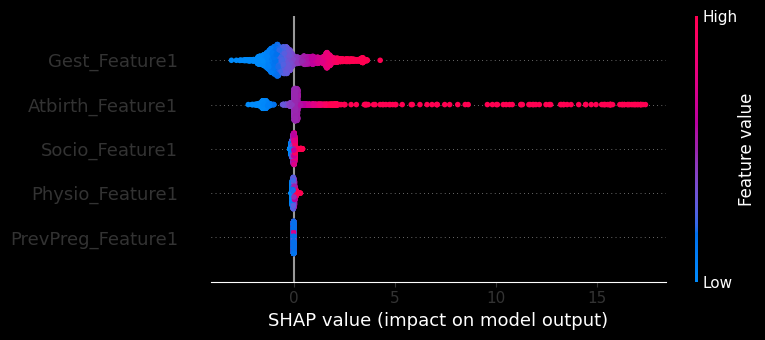

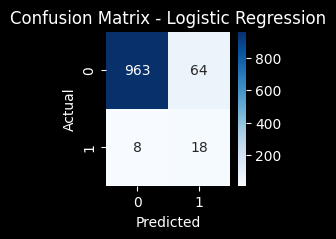

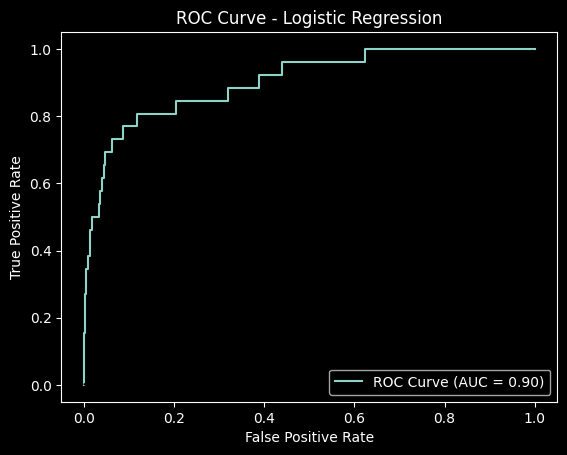


F1 Scores for All Models:
Logistic Regression: 0.3333


In [434]:
warnings.filterwarnings("ignore")
print("*"*20," LDA all 5 buckets ","*"*20)
X = X_lda_all5
y=label
shapely(X,y)

********************  All 5 buckets  ********************


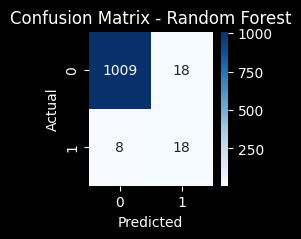

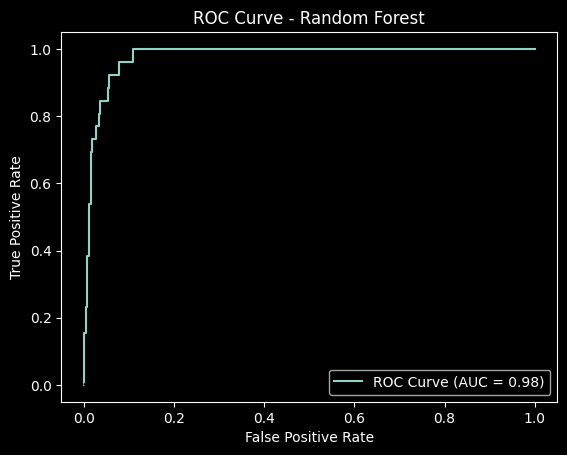


F1 Scores for All Models:
Random Forest: 0.5806


In [435]:
warnings.filterwarnings("ignore")
print("*"*20," All 5 buckets ","*"*20)
X = All_5_DataScaled
y=label
modelOutput(X,y)

********************  All 4 buckets  ********************


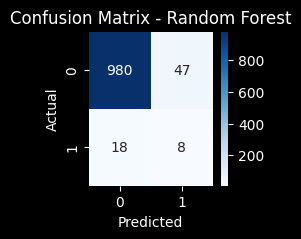

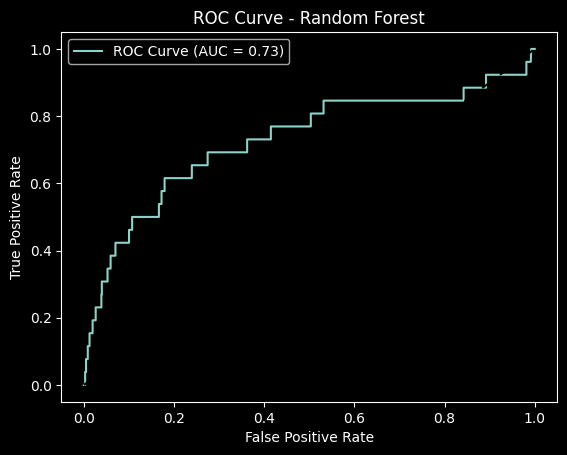


F1 Scores for All Models:
Random Forest: 0.1975


In [436]:
warnings.filterwarnings("ignore")
print("*"*20," All 4 buckets ","*"*20)
X = All_4_DataScaled
y=label
modelOutput(X,y)

In [437]:
from collections import Counter
from sklearn.metrics import f1_score, recall_score, precision_score
import shap


def shapely(X,y):

    warnings.filterwarnings("ignore")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=label, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train=X_train_resampled
    y_train=y_train_resampled


    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced' , C= 0.01, penalty= 'l1', solver= 'liblinear'),
    }


    f1_scores = {}

    

    for model_name, model in models.items():
        model.fit(X_train, y_train)

        # Create SHAP explainer
        explainer = shap.Explainer(model, X_train)
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_train)
        # Visualize the SHAP values
        print(shap_values.shape)
        shap.summary_plot(shap_values, X_train)

        # Apply the threshold
        y_prob = model.predict_proba(X_test)[:, 1]
        y_train_prob = model.predict_proba(X_train)[:, 1]


        thresholds = {
        "Logistic Regression": 0.65,
        }

        # Set the default threshold to 0.5 if the model is not specified in the dictionary
        threshold = thresholds.get(model_name, 0.5)
        y_pred = (y_prob >= threshold).astype(int)
        y_train_pred = (y_train_prob >= threshold).astype(int)


        f1 = f1_score(y_test, y_pred) 
        f1_scores[model_name] = f1

                # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(2, 2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


        # ROC-AUC
        roc_auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve - {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()



    # Display the F1 scores for all models
    print("\nF1 Scores for All Models:")
    for model_name, score in f1_scores.items():
        print(f"{model_name}: {score:.4f}")


********************  SHAP: Usable Data LDAs  ********************
(4792, 4)


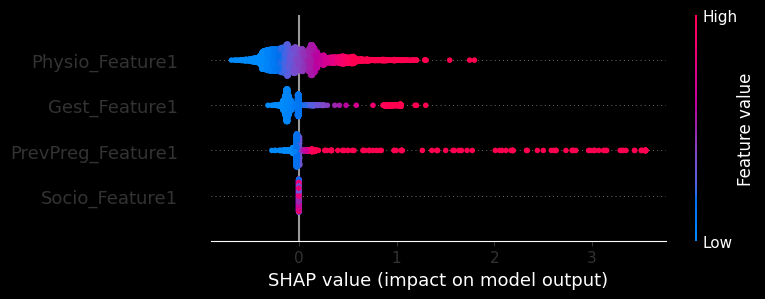

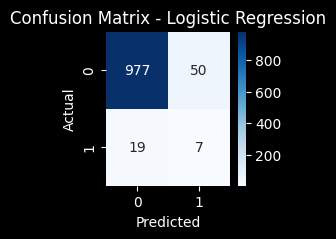

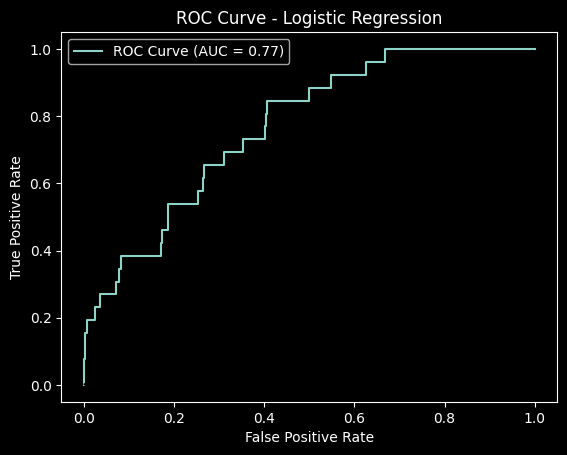


F1 Scores for All Models:
Logistic Regression: 0.1687


In [438]:

warnings.filterwarnings("ignore")
print("*"*20," SHAP: Usable Data LDAs ","*"*20)
X = usableData
y=label
shapely(X,y)    

In [439]:
X = usableData[['Physio_Feature1','PrevPreg_Feature1']]
y=label
lda = LinearDiscriminantAnalysis(n_components=1)  
impFeature = lda.fit_transform(X, y)
print("Shape of transformed data:", impFeature.shape)

Shape of transformed data: (3508, 1)


********************  Using top 2 lda features  ********************
(4792, 1)


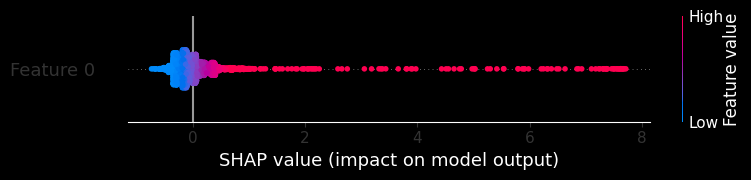

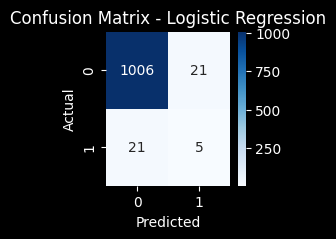

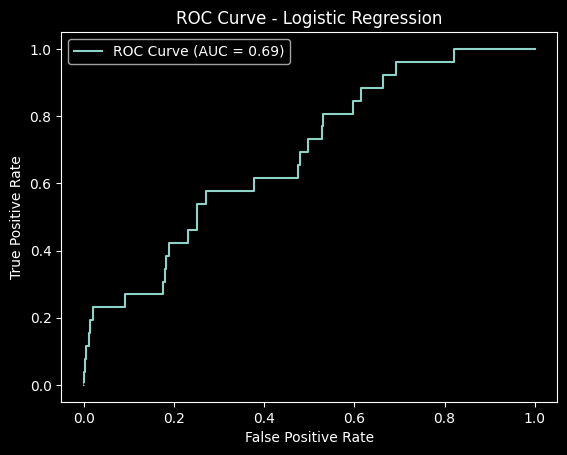


F1 Scores for All Models:
Logistic Regression: 0.1923


In [440]:

warnings.filterwarnings("ignore")
print("*"*20," Using top 2 lda features ","*"*20)
X = impFeature
y=label
shapely(X,y)

In [441]:
physio_data_clean.columns

Index(['SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT', 'BIRTH_OUTCOME'], dtype='object')

********************  SHAP: Physiological Data  ********************
(4792, 4)


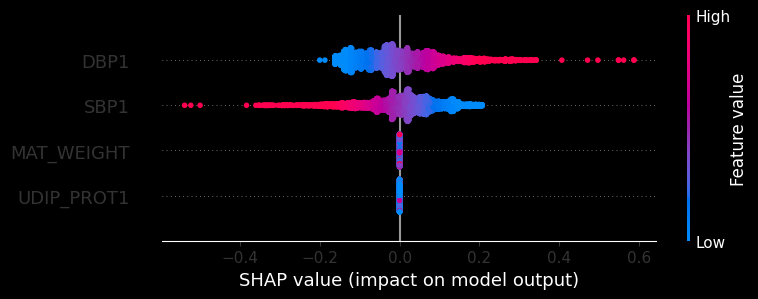

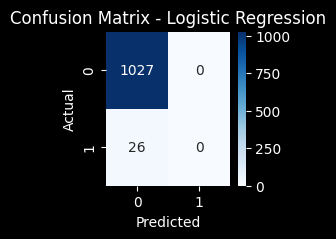

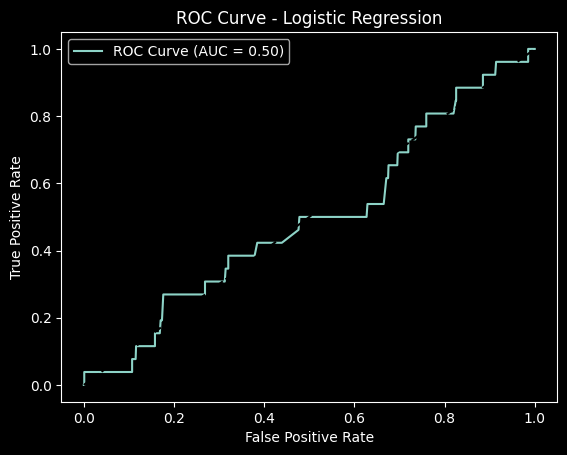


F1 Scores for All Models:
Logistic Regression: 0.0000


In [442]:

warnings.filterwarnings("ignore")
print("*"*20," SHAP: Physiological Data ","*"*20)
X = physio_data_clean.drop(columns=['BIRTH_OUTCOME'])
y=label
shapely(X,y)

In [443]:
usableData_raw.columns

Index(['PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP', 'PREV_CS',
       'stillbirthCount', 'normalbirthCount', 'PW_AGE', 'PW_EDUCATION',
       'WEALTH_INDEX', 'SBP1', 'DBP1', 'UDIP_PROT1', 'MAT_WEIGHT',
       'SINGLE_TWIN', 'GRAVIDITY', 'PARITY', 'APH', 'BIRTH_OUTCOME'],
      dtype='object')

********************  SHAP: All usable features  ********************
(4792, 18)


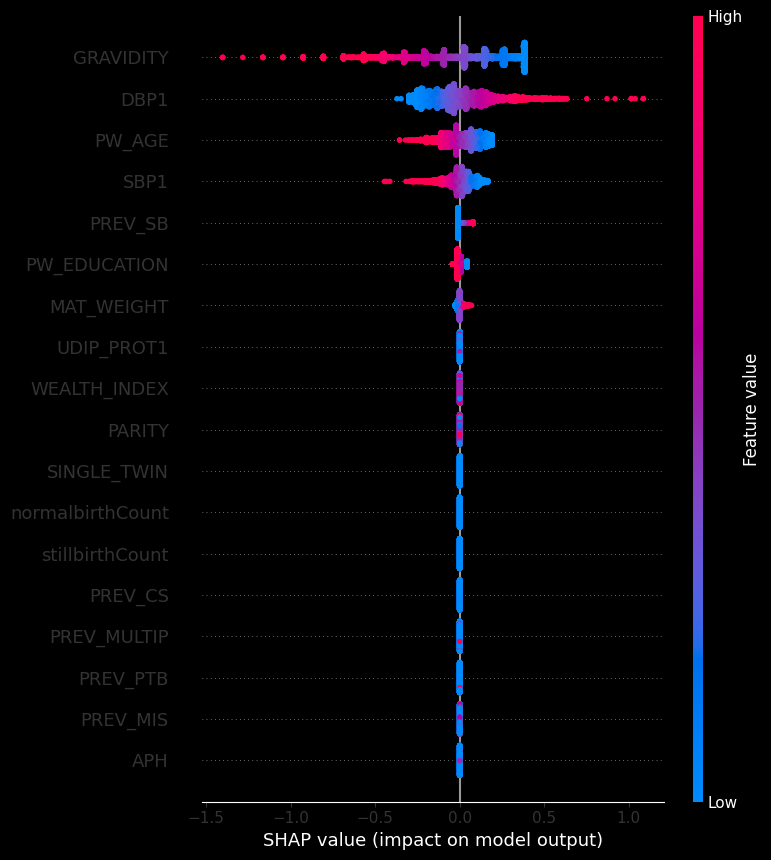

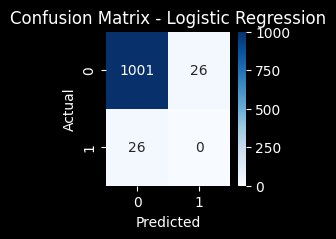

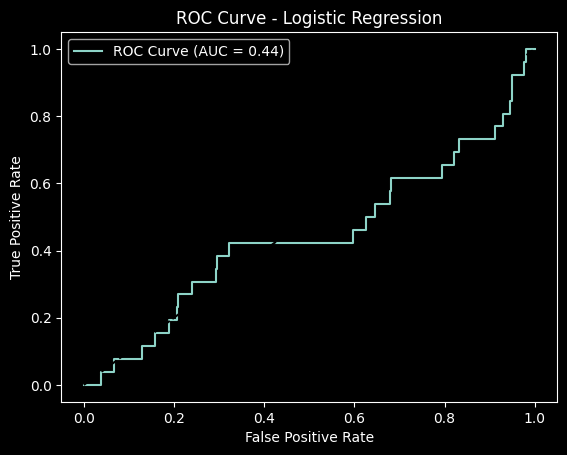


F1 Scores for All Models:
Logistic Regression: 0.0000


In [444]:
warnings.filterwarnings("ignore")
print("*"*20," SHAP: All usable features ","*"*20)
X = usableData_raw.drop(columns=['BIRTH_OUTCOME'])
y=label
shapely(X,y)

********************  SHAP: Gestational Data  ********************
(4792, 6)


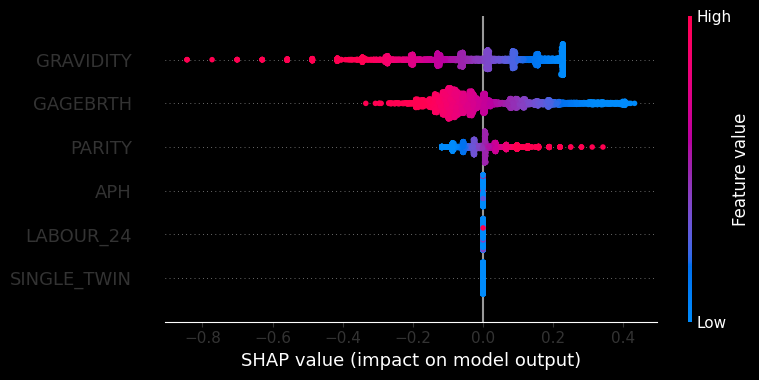

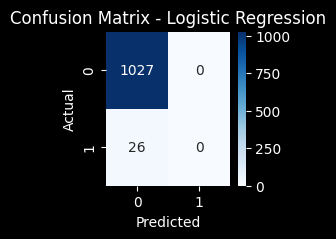

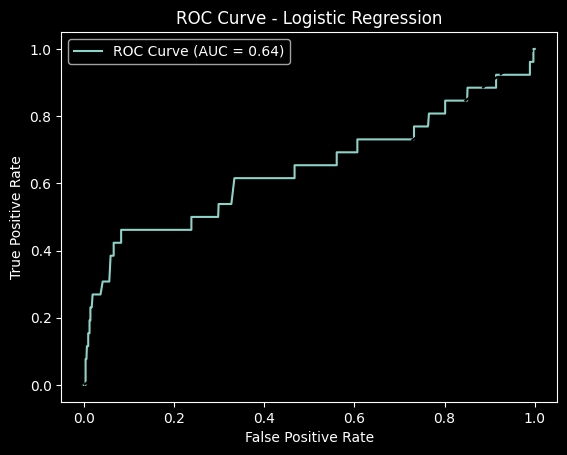


F1 Scores for All Models:
Logistic Regression: 0.0000


In [445]:

warnings.filterwarnings("ignore")
print("*"*20," SHAP: Gestational Data ","*"*20)
X = gestation_data_clean.drop(columns=['BIRTH_OUTCOME'])
y=label
shapely(X,y)

# Final Model

In [446]:
from collections import Counter
from sklearn.metrics import f1_score, recall_score, precision_score
import shap


def finalModel(X,y):

    warnings.filterwarnings("ignore")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=label, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train=X_train_resampled
    y_train=y_train_resampled


    model = LogisticRegression(max_iter=1000, class_weight='balanced' , C= 0.01, penalty= 'l1', solver= 'liblinear')


    
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    y_train_prob = model.predict_proba(X_train)[:, 1]
    threshold= 0.65
    y_pred = (y_prob >= threshold).astype(int)
    y_train_pred = (y_train_prob >= threshold).astype(int)


    f1 = f1_score(y_test, y_pred) 
    
     # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Logistic Regression")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - Logistic Regression")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()



    # Display the F1 scores for all models
    print(f"\nF1 Score:: {f1:.4f}")


********************  lda: usable data  ********************


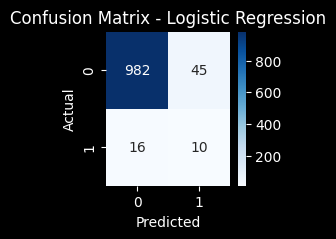

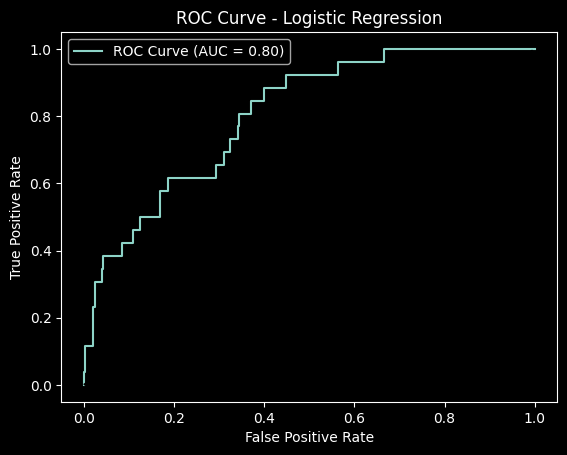


F1 Score:: 0.2469
********************  All 5 buckets  ********************


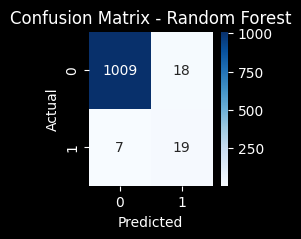

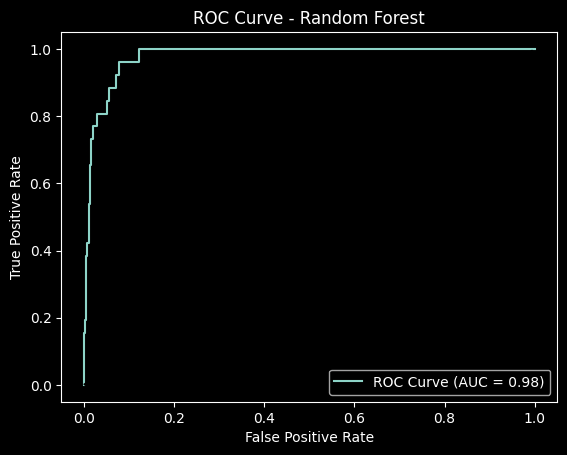


F1 Scores for All Models:
Random Forest: 0.6032


In [448]:

warnings.filterwarnings("ignore")
print("*"*20," lda: usable data ","*"*20)
X = usableData_lda
y=label
finalModel(X,y)


warnings.filterwarnings("ignore")
print("*"*20," All 5 buckets ","*"*20)
X = All_5_DataScaled
y=label
modelOutput(X,y)